# Introduction

The notebook's objective for this milestone is to intimately familiarize ourselves with the data, perform thorough preprocessing, and execute all essential descriptive statistical tasks and showcasing the feasibility of our project goals.

General organization of this notebook:
- Handle size of the data
- EDA
- Data preprocessing
- Feasibility check of projects' methods
- Alternatives considered

In [18]:
# import all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import os
import warnings
import spacy

from textblob import TextBlob
from IPython.display import display, HTML, Markdown

from sklearn.feature_extraction.text import CountVectorizer

import string
import nltk
nltk.download('all')
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud
from collections import Counter

warnings.filterwarnings('ignore') # remove the warnings

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_d

In [19]:
output_plot_folder = "docs/assets/plot/"
output_img_folder = "imgs/"

In [20]:
# A function is defined to save the plots in .html and .png format
def plot_format (fig, name):
    fig.write_html(output_plot_folder + name + ".html")
    fig.write_image(output_img_folder + name + ".png", engine="kaleido")

    #Show plot image in notebook
    return Image(output_img_folder + name + ".png")

---

## Handle size of the data

### Load ratings.txt

We are processing data extracted from two similar beer rating websites: BeerAdvocate and RateBeer. The primary data structure is outlined in "ratings.txt," which includes user reviews providing information on beer (names, IDs, style, alcohol by volume), breweries, and users (date of review, user details, ratings, and comments on various aspects). Other supporting files include "beers.csv" (aggregated ratings for each beer), "Breweries" (information on breweries and their locations), and "Users" (user details on the number of ratings, reviews, and country of origin).

The most crucial file is "ratings.txt," as others are derived from its content. Due to its significant size (4.3 GB for BeerAdvocate and 3.95 GB for RateBeer), loading directly with a standard pipeline is impractical due to laptop memory limitations. To address this, we split the .txt files into N subfiles and load the data iteratively using a function.

The function allows control over the fraction of initial data loaded via the parameter **Nb_files**, which determines the number of subfiles to load. It also accommodates inherent differences between the two websites, such as additional review columns for BeerAdvocate.

Once loaded into DataFrames, we utilize the sample_data function to randomly sample a fraction of the data, enabling efficient handling of the substantial dataset.

In [21]:
def load_txt_file(website, Nb_files):
    if website == 'BeerAdvocate':
        # Specify the directory containing the text files 
        # Need to be outside of the repo folder and might need to change the path according to one's unique folders configuration
        directory = './../dataset_BeerReviews/BeerAdvocate/ratings_split_BA/'
    else:
        directory = './../dataset_BeerReviews/RateBeer/ratings_split_RB/'

    # Initialize an empty list to store DataFrames
    dfs = []

    # Loop through the files in reverse order (ratings-5.txt to ratings-1.txt)
    for i in range(Nb_files, 0, -1):
        file_name = f'ratings-{i}.txt'
        file_path = os.path.join(directory, file_name)

        with open(file_path, 'r') as f:
            text = f.read()

        # Remove double quotes at the beginning of each line
        data = re.sub('"', '', text)
        data = re.sub(r'^"', '', data, flags=re.MULTILINE)

        # Split the text into individual beer reviews
        beer_reviews = data.split('beer_name')

        # Extract the beer information from each review
        beer_data = []
        for review in beer_reviews:
            beer_info = {}
            for line in [entry.split(':', 1) for entry in review.split('\n') if ':' in entry]:# and 'text' not in entry]:
                if line:  # Check if the list is not empty
                    key, value = line[0].strip(), line[1].strip()
                    beer_info[key] = value
            beer_data.append(beer_info)

        # Convert the beer data into a DataFrame
        df = pd.DataFrame(beer_data)

        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    final_df = pd.concat(dfs, ignore_index=True)

    # Rename the columns depending on the website
    if website == 'BeerAdvocate':
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text',
            'review'] # additional column compared to RB
    else:
        final_df.columns = [
            'beer_name',
            'beer_id',
            'brewery_name',
            'brewery_id',
            'style',
            'abv',
            'date',
            'user_name',
            'user_id',
            'appearance',
            'aroma',
            'palate',
            'taste',
            'overall',
            'rating',
            'text']
    return final_df

def sample_data(df, ratio):
    # sample the data to make it even smaller
    return df.sample(frac = ratio, random_state=42)

In [22]:
# Load data : for faster processing, we will only load 1 file out of the whole dataset
ratings_BA = load_txt_file('BeerAdvocate', 1)
ratings_RB = load_txt_file('RateBeer', 1)

In [23]:
# Sample data to make it even smaller AND RANDOMIZED (not randomized in the initial txt splitting process)
ratings_BA = sample_data(df = ratings_BA, ratio = 0.1)
ratings_RB = sample_data(df = ratings_RB, ratio = 0.1)

In [24]:
print(f"Length of ratings_BA (BeerAdvocate) dataframe : {len(ratings_BA)}")
print(f"Length of ratings_RB (RateBeer) dataframe : {len(ratings_RB)}")
display(ratings_BA.head(2),ratings_RB.head(2))

Length of ratings_BA (BeerAdvocate) dataframe : 44434
Length of ratings_RB (RateBeer) dataframe : 44680


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
43736,"Hello, My Name Is Ingrid",67199,BrewDog,16315,American Double / Imperial IPA,8.2,1370426400,aztraz,aztraz.671249,nan,nan,nan,nan,nan,3.50,nan,False
273843,Solstice D'été Aux Cerises,73716,Brasserie Dieu du Ciel!,1141,Berliner Weissbier,6.5,1444644000,hopsolutely,hopsolutely.513175,4.0,4.0,3.5,4.0,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
262500,Brew Brothers Prairie Berry Ale,21927,Brew Brothers Brewing &#40;Alberta&#41;,3033,Fruit Beer,5.5,1044615600,presario,5348,3,6,3,7,13,3.20,Big blue 1L bottle. Very loud pop announced t...
39881,Ed Hardy Premium Beer,110849,Cervecería Mexicana (Grupo Modelo),5973,Pale Lager,4.6,1281520800,Cajun,47922,2,4,2,3,5,1.60,Tasting - Gulf Brew 2010 - Pale amber white he...


### Load the other data

In [25]:
# BeerAdvocate
beers_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/beers.csv")
breweries_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/breweries.csv")
users_BA = pd.read_csv("./dataset_BeerReviews/BeerAdvocate/users.csv")

# RateBeer
beers_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/beers.csv")
breweries_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/breweries.csv")
users_RB = pd.read_csv("./dataset_BeerReviews/RateBeer/users.csv")

# matched_beer_data
beers_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/beers.csv", header=1)
breweries_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/breweries.csv", header = 1)
ratings_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/ratings.csv", header=1)
users_approx = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users_approx.csv", header=1)
users_matched = pd.read_csv("./dataset_BeerReviews/matched_beer_data/users.csv", header=1)

## Concatenate the two dataframes

In [26]:
"""
def add_location(breweries_df, users_df, ratings_df):
    ## Breweries
    # Rename the column 'id' to 'brewery_id' in breweries_df
    breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)
    breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
    # Convert 'brewery_id' to str in both DataFrames before merging
    breweries_df['brewery_id'] = breweries_df['brewery_id'].astype(str)
    ratings_df['brewery_id'] = ratings_df['brewery_id'].astype(str)

    # Add location of the brewery
    ratings_df_merged = pd.merge(ratings_df, breweries_df[['brewery_id', 'brewery_location']], on='brewery_id', how='left')

    # Change the order of the columns
    last_column_b = ratings_df_merged.pop('brewery_location')
    ratings_df_merged.insert(4, 'brewery_location', last_column_b)

    ## Users
    users_df.rename(columns={'location': 'user_location'}, inplace=True)
    # Add location of the user
    users_df['user_id'] = users_df['user_id'].astype(str)
    ratings_df_merged['user_id'] = ratings_df_merged['user_id'].astype(str)

    ratings_df_merged = pd.merge(ratings_df_merged, users_df[['user_id', 'user_location']], on='user_id', how='left')

    # Change the order of the columns
    last_column_u = ratings_df_merged.pop('user_location')
    ratings_df_merged.insert(10, 'user_location', last_column_u)
    return ratings_df_merged

def add_location_matched(breweries_df, users_df, ratings_df):
    # Rename the column 'id' to 'brewery_id' in breweries_df
    breweries_df.rename(columns={'id': 'brewery_id'}, inplace=True)
    breweries_df.rename(columns={'location': 'brewery_location'}, inplace=True)
    # Convert 'brewery_id' to str in both DataFrames before merging
    breweries_df['brewery_id'] = breweries_df['brewery_id'].astype(str)
    ratings_df['brewery_id'] = ratings_df['brewery_id'].astype(str)

    # Add location of the brewery
    ratings_df_merged = pd.merge(ratings_df, breweries_df[['brewery_id', 'brewery_location']], on='brewery_id', how='left')

    # Change the order of the columns
    column_1 = ratings_df_merged.pop('brewery_location')
    ratings_df_merged.insert(7, 'brewery_location', column_1)
    ratings_df_merged.insert(25, 'brewery_location.1', column_1)

    ## Users
    users_df.rename(columns={'location': 'user_location'}, inplace=True)
    # Add location of the user
    users_df['user_id'] = users_df['user_id'].astype(str)
    ratings_df_merged['user_id'] = ratings_df_merged['user_id'].astype(str)

    ratings_df_merged = pd.merge(ratings_df_merged, users_df[['user_id', 'user_location']], on='user_id', how='left')

    # Change the order of the columns
    column_1 = ratings_df_merged.pop('user_location')
    ratings_df_merged.insert(18, 'user_location', column_1)
    ratings_df_merged.insert(36, 'user_location.1', column_1)
    return ratings_df_merged
"""

In [27]:
"""
# Modify the data before concatenating (to add locations of users and breweries)
ratings_BA_merged = add_location(breweries_BA, users_BA, ratings_BA)
ratings_RB_merged = add_location(breweries_RB, users_RB, ratings_RB)
ratings_matched_merged = add_location_matched(breweries_matched, users_approx, ratings_matched)
"""

In [114]:
def add_location(breweries_df, users_df, ratings_df, brewery_location_indices, user_location_indices):
    # Rename the columns and convert 'brewery_id' and 'user_id' to str
    breweries_df = breweries_df.rename(columns={'id': 'brewery_id', 'location': 'brewery_location'})
    breweries_df['brewery_id'] = breweries_df['brewery_id'].astype(str)
    users_df = users_df.rename(columns={'location': 'user_location'})
    users_df['user_id'] = users_df['user_id'].astype(str)
    ratings_df['brewery_id'] = ratings_df['brewery_id'].astype(str)
    ratings_df['user_id'] = ratings_df['user_id'].astype(str)

    # Merge the DataFrames
    ratings_df_merged = pd.merge(ratings_df, breweries_df[['brewery_id', 'brewery_location']], on='brewery_id', how='left')
    ratings_df_merged = pd.merge(ratings_df_merged, users_df[['user_id', 'user_location']], on='user_id', how='left')

    # Change the order of the columns
    for index in brewery_location_indices:
        column_b = ratings_df_merged.pop('brewery_location')
        ratings_df_merged.insert(index, 'brewery_location', column_b)
    for index in user_location_indices:
        column_u = ratings_df_merged.pop('user_location')
        ratings_df_merged.insert(index, 'user_location', column_u)

    return ratings_df_merged

In [115]:
ratings_BA_merged = add_location(breweries_BA, users_BA, ratings_BA, [4], [9])
ratings_RB_merged = add_location(breweries_RB, users_RB, ratings_RB, [4], [9])
ratings_matched_merged = add_location(breweries_matched, users_approx, ratings_matched, [7, 27], [11, 23])

In [118]:
display(ratings_BA_merged.head(20),ratings_RB_merged.head(20),ratings_matched_merged.columns)

,beer_name,beer_id,brewery_name,brewery_id,brewery_location,style,abv,date,user_name,user_location,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,"Hello, My Name Is Ingrid",67199.0,BrewDog,16315.0,NaN,American Double / Imperial IPA,8.2,1370426400,aztraz,Sweden,aztraz.671249,NaN,NaN,NaN,NaN,NaN,3.50,nan,False
1,Solstice D'été Aux Cerises,73716.0,Brasserie Dieu du Ciel!,1141.0,NaN,Berliner Weissbier,6.5,1444644000,hopsolutely,Canada,hopsolutely.513175,4.00,4.00,3.5,4.00,3.75,3.90,Enjoying with thanks to Phyl21ca.Rarely does a...,True
2,O'Hanlons Organic Rye,9123.0,O'Hanlon Brewing Co. Ltd.,1533.0,NaN,Rye Beer,5.0,1214733600,aerozeppl,"United States, New York",aerozeppl.101084,3.00,3.00,4.0,3.00,3.00,3.10,A: 2 Finger pour. White head with some piting....,True
3,Fraoch Heather Ale,245.0,Williams Brothers Brewing Company,12142.0,NaN,Scottish Gruit / Ancient Herbed Ale,5.0,1375869600,ekalb31,"United States, North Carolina",ekalb31.747152,NaN,NaN,NaN,NaN,NaN,3.50,nan,False
4,Samuel Smith's Pure Brewed Organic Lager Beer,778.0,Samuel Smith Old Brewery (Tadcaster),113.0,NaN,Euro Pale Lager,5.0,1160560800,jasonjlewis,"United States, Texas",jasonjlewis.74038,4.00,4.50,4.0,4.00,4.00,4.12,This beer is really a no frills beer to relax ...,True
5,Pale Ale (Mosaic),90924.0,The Kernel Brewery,23249.0,NaN,American Pale Ale (APA),5.1,1416481200,olradetbalder,Sweden,olradetbalder.560899,NaN,NaN,NaN,NaN,NaN,3.50,nan,False
6,Mill Street Father John's Ale,68193.0,Mill Street Brew Pub,3760.0,NaN,Extra Special / Strong Bitter (ESB),6.3,1303034400,Sammy,Canada,sammy.3853,4.00,3.50,2.5,2.50,3.00,2.93,Poor for style. On tap at Gambrinus. Orange co...,True
7,Hardcore IPA,41505.0,BrewDog,16315.0,NaN,American Double / Imperial IPA,9.2,1408010400,Ansonosman,NaN,ansonosman.840378,NaN,NaN,NaN,NaN,NaN,3.88,nan,False
8,Hobgoblin,236.0,Wychwood Brewery Company Ltd,160.0,NaN,Extra Special / Strong Bitter (ESB),5.2,1276077600,MarvinSnyder,"United States, West Virginia",marvinsnyder.274163,4.50,4.50,4.0,4.00,4.00,4.15,6-9-10 - poured into a Samuel Smith pint glass...,True
9,Dark Chocolate Porter,79486.0,Lighthouse Brewing Company,2385.0,NaN,English Porter,5.5,1400752800,CWVegas,"United States, Nevada",cwvegas.735758,NaN,NaN,NaN,NaN,NaN,3.75,nan,False


,beer_name,beer_id,brewery_name,brewery_id,brewery_location,style,abv,date,user_name,user_location,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Brew Brothers Prairie Berry Ale,21927.0,Brew Brothers Brewing &#40;Alberta&#41;,3033.0,NaN,Fruit Beer,5.5,1044615600,presario,Canada,5348,3.0,6.0,3.0,7.0,13.0,3.2,Big blue 1L bottle. Very loud pop announced t...
1,Ed Hardy Premium Beer,110849.0,Cervecería Mexicana (Grupo Modelo),5973.0,NaN,Pale Lager,4.6,1281520800,Cajun,"United States, Louisiana",47922,2.0,4.0,2.0,3.0,5.0,1.6,Tasting - Gulf Brew 2010 - Pale amber white he...
2,Barnstormer Billy Bishop Brown,234971.0,Barnstormer Brewing,17952.0,NaN,Brown Ale,3.8,1447498800,crazy_cat_lady,NaN,252434,3.0,6.0,3.0,5.0,15.0,3.2,Can in Brew Box. Very dark brown with tan head...
3,Dieu du Ciel Route des Épices,15138.0,Dieu du Ciel,364.0,NaN,Spice/Herb/Vegetable,5.0,1190541600,MartinT,Canada,4919,4.0,7.0,4.0,7.0,15.0,3.7,My Bottom Line:This wondrous Black Pepper Rye ...
4,Dieu du Ciel Péché Mortel,11461.0,Dieu du Ciel,364.0,NaN,Imperial Stout,9.5,1267614000,Frank,"United States, Illinois",5777,4.0,6.0,3.0,8.0,15.0,3.6,I recall first trying this at a Dark Lord Day ...
5,Dos Equis XX Special Lager,225.0,FEMSA - Cuauhtémoc-Moctezuma (Heineken),46.0,NaN,Pale Lager,4.2,1083751200,jpknight22,"United States, North Carolina",5248,3.0,5.0,2.0,4.0,9.0,2.3,"Yeah, finally made myself try this on a cinco ..."
6,La Fabrique Simonne,339443.0,La Fabrique,11271.0,NaN,Witbier,5.0,1434794400,mathieuc,Canada,142195,3.0,8.0,4.0,8.0,15.0,3.8,Mondial 2015. Pours a hazy copper/red with a l...
7,Labatt Ice Beer,253.0,Labatt Breweries &#40;AB InBev&#41;,51.0,NaN,Pale Lager,5.6,1213437600,AdamSkillin,"United States, New Jersey",10440,2.0,2.0,2.0,2.0,8.0,1.6,They lower this beerâs temperature until ice...
8,Indio,231.0,FEMSA - Cuauhtémoc-Moctezuma (Heineken),46.0,NaN,Amber Lager/Vienna,4.1,1342087200,TheGrandMaster,New Zealand,16264,2.0,4.0,2.0,4.0,5.0,1.7,Bottle. All these macro Mexican beers are star...
9,Russell Rick August Russian Imperial Stout,175273.0,Russell Brewing Company,3185.0,NaN,Imperial Stout,10.8,1344333600,Gerbeer,Canada,165781,5.0,7.0,4.0,8.0,15.0,3.9,650 ml bottle. Pours black with large dark tan...


Index(['abv', 'appearance', 'aroma', 'beer_id', 'beer_name', 'brewery_id',
       'brewery_name', 'date', 'overall', 'palate', 'rating', 'review',
       'style', 'taste', 'text', 'brewery_location', 'user_id', 'user_name',
       'abv.1', 'appearance.1', 'aroma.1', 'beer_id.1', 'beer_name.1',
       'user_location', 'brewery_id.1', 'brewery_name.1', 'date.1',
       'overall.1', 'palate.1', 'rating.1', 'style.1', 'taste.1', 'text.1',
       'user_id.1', 'user_name.1'],
      dtype='object')

In [31]:
## Modify the matched dataset to have the same columns as the other datasets
# Rename the columns
ratings_matched_test = ratings_matched_merged.copy(deep=True)
ratings_matched_test['beer_id.1'] = ratings_matched_test['beer_id']
ratings_matched_test['brewery_id.1'] = ratings_matched_test['brewery_id']
ratings_matched_test['beer_name.1'] = ratings_matched_test['beer_name']
ratings_matched_test['brewery_name.1'] = ratings_matched_test['brewery_name']
ratings_matched_test['brewery_location.1'] = ratings_matched_test['brewery_location']
ratings_matched_test['user_location.1'] = ratings_matched_test['user_location']

# Separate the matched dataset into 2 parts
ratings_matched_test_1 = ratings_matched_test.iloc[:, :19]
ratings_matched_test_1 = ratings_matched_test_1.drop(['review'], axis=1)
ratings_matched_test_2 = ratings_matched_test.iloc[:, 19:]

# Change the ratings to be on the same scale as the other datasets
ratings_matched_test_2['overall.1'] = ratings_matched_test_2['overall.1']*5/20
ratings_matched_test_2['aroma.1'] = ratings_matched_test_2['aroma.1']*5/10
ratings_matched_test_2['taste.1'] = ratings_matched_test_2['taste.1']*5/10
ratings_matched_test_1 = ratings_matched_test_1.sort_index(axis=1)
ratings_matched_test_2 = ratings_matched_test_2.sort_index(axis=1)

# Rename the columns to have the same name as the other datasets
ratings_matched_test_2.columns = ratings_matched_test_1.columns

# Concatenate the 2 parts
ratings_matched_test = pd.concat([ratings_matched_test_1, ratings_matched_test_2], axis=0)
ratings_matched_test.sort_values(by=['beer_id', 'user_id'], inplace=True)

# Concatenate all the data
all_data= pd.concat([ratings_matched_test, ratings_BA_merged,ratings_RB_merged], axis=0)
display(all_data.head(10))

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_location,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_location,user_name,review
9162,6.0,5.0,4.0,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1049882400,3.75,4.0,4.0,Imperial Stout,4.0,What a magnificent site to these tired old eye...,46,"United States, Arizona",Gusler,NaN
1192,6.0,5.0,3.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.25,4.0,4.1,Imperial Stout,4.0,Thanks to Darkover for the trade. Considering ...,2714,"United States, Ohio",Dogbrick,NaN
8947,6.0,3.0,2.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1052560800,2.75,2.0,2.6,Imperial Stout,2.5,What a freaking joke. This was by far the wors...,3782,"United States, Georgia",aracauna,NaN
13092,6.0,4.0,4.0,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1079780400,3.5,3.0,3.5,Imperial Stout,3.0,Opaque black with a khaki brown head that stan...,9520,"United States, Georgia",rajendra82,NaN
13038,6.0,5.0,3.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1121335200,3.5,3.0,3.6,Imperial Stout,3.5,from the bottle. poured black with a small bro...,10189,"United States, Michigan",walleye,NaN
21879,6.0,4.0,3.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1174042800,3.75,4.0,3.7,Imperial Stout,3.5,This beer looks dark with a dark brown head. I...,20079,"United States, California",OStrungT,NaN
8947,6.0,3.0,2.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1052560800,3.0,2.5,2.63,Russian Imperial Stout,2.5,What a freaking joke. This was by far the wors...,aracauna.324,"United States, Georgia",aracauna,NaN
1192,6.0,4.5,4.0,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.0,4.0,4.03,Russian Imperial Stout,4.0,"Considering this is my favorite style of beer,...",dogbrick.487,"United States, Ohio",Dogbrick,NaN
9162,6.0,5.0,4.0,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1049882400,4.0,4.0,4.06,Russian Imperial Stout,4.0,What a magnificent site to these tired old eye...,gusler.811,"United States, Arizona",Gusler,NaN
21879,6.0,4.0,3.5,12,Bert Grant's Imperial Stout,5,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1102849200,4.0,4.0,3.68,Russian Imperial Stout,3.5,This beer looks dark with a dark brown head. I...,ostrungt.6663,"United States, California",OStrungT,NaN


---

## EDA

**Organisation of the EDA**
- General
- Numerical ratings
- Textual reviews

### 1. General

**Formats**

One can see that all the features of **ratings_BA** and **ratings_RB** have a `object` type, which is not very convenient if we want to automate the visualization process, for example plotting the distribution of the numerical features in histograms. As a first preprocessing step, we will thus convert the type of the numerical variables to `float64` with the function **convert_type** below.

In [32]:
# Convert the numerical features to float
def convert_type(df, col):
    df[col] = df[col].astype('float64')
    return df

# columns including the numerical features for both websites
# user_id is numerical in RB but categorical in BA so we don't include it
numerical_cols = ['beer_id', 'brewery_id', 'abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

for col in numerical_cols : 
    all_data = convert_type(all_data, col)
    ratings_BA = convert_type(ratings_BA, col)
    ratings_RB = convert_type(ratings_RB, col)

**Descriptive statistics**

We can see the missing values per feature in each dataframe.

In [33]:
def get_feature_stats(df):
        """
        Obtains descriptive statistics for all features and percentage of missing values

        Parameters
        ----------
        df : DataFrame containing all data
        
        Returns
        -------
        stats : DataFrame containing the statistics for all features.
        """
        # Calculate numerical descriptive statistics 
        numerical = df.describe(include= ['float64', 'int64'])
        # Calculate categorical descriptive statistics
        categorical = df.describe(include= ['object'])
        # Combine numerical and categorical statistics into a single DataFrame
        stats = pd.concat([numerical, categorical])
        
        # Select specific statistics for the output
        stats = stats.loc[['mean', 'std', '50%', 'unique', 'freq', 'max']]
        # Calculate the percentage of missing values for each feature
        percentage = df.isnull().sum(axis = 0)*100 / len(df)
        # Add a row to the DataFrame containing the percentage of missing values for each feature
        stats.loc['missing_values'] = np.array(percentage)
        return stats

In [34]:
display(get_feature_stats(all_data))

,abv,appearance,aroma,beer_id,brewery_id,overall,palate,rating,taste,beer_name,brewery_location,brewery_name,date,style,text,user_id,user_location,user_name,review
mean,6.406696,3.557643,4.570833,91075.358917,8804.860221,7.109923,3.410388,3.467795,4.622962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.118976,0.751962,1.703841,108965.726128,11373.957357,4.854019,0.799589,0.742595,1.714635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.700000,3.750000,4.000000,52881.000000,2213.000000,4.250000,3.500000,3.600000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28503,142,4261,10918,172,99146,21232,151,20110,2
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,981,56688,3755,92,6448,24917,2182,42875,4343,25533
max,65.000000,5.000000,10.000000,536439.000000,49808.000000,20.000000,5.000000,5.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing_values,1.077645,14.300207,14.300207,0.000751,0.000000,0.000751,0.000751,0.000751,0.000751,14.300207,14.300207,0.000751,0.000751,14.300207,2.774521,0.0,2.809842,0.000751,66.608802


In [35]:
df1 = get_feature_stats(breweries_BA)
df2 = get_feature_stats(breweries_RB)
df3 = get_feature_stats(users_BA)
df4 = get_feature_stats(users_RB)

# Using HTML/CSS to display DataFrames in the same row
html = f'<div style="display: flex; flex-direction: row;"> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Breweries BeerAdvocate</h3>{df1.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 100px;"> \
                <h3>Breweries RateBeer</h3>{df2.to_html()} \
            </div> \
            <div style="text-align: center; margin-right: 20px;"> \
                <h3>Users BeerAdovate</h3>{df3.to_html()} \
            </div> \
            <div style="text-align: center;"> \
                <h3>Users RateBeer</h3>{df4.to_html()} \
            </div> \
        </div>'

display(HTML(html))

,nbr_beers,brewery_id,brewery_location,name
mean,21.056331,NaN,NaN,NaN
std,69.417841,NaN,NaN,NaN
50%,6.000000,NaN,NaN,NaN
unique,NaN,16758,297,16237
freq,NaN,1,1431,34
max,1196.000000,NaN,NaN,NaN
missing_values,0.000000,0.0,0.0,0.0
,nbr_beers,brewery_id,brewery_location,name
mean,19.022655,NaN,NaN,NaN
std,31.542620,NaN,NaN,NaN


**Graphical descriptions**

- **Users**

In [36]:
display(users_BA.head(2), users_RB.head(2), users_matched.head(2))

,nbr_ratings,nbr_reviews,user_id,user_name,joined,user_location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"


,nbr_ratings,user_id,user_name,joined,user_location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain


,joined,location,nbr_ratings,nbr_reviews,user_id,user_name,user_name_lower,joined.1,location.1,nbr_ratings.1,user_id.1,user_name.1,user_name_lower.1
0,1.220868e+09,Germany,6,6,erzengel.248045,Erzengel,erzengel,1.224324e+09,Germany,8781,83106,Erzengel,erzengel
1,1.348394e+09,"United States, Virginia",1,1,gendv138.695700,GenDV138,gendv138,1.385723e+09,"United States, Virginia",6240,290599,GenDV138,gendv138


In [37]:
print(f"\nNumber of unique users (based on user_name) in BeerAdvocate: {len(users_BA['user_name'].unique())}")
print(f"Number of unique users (based on user_name) in RateBeer: {len(users_RB['user_name'].unique())}")

print(f"\nNumber of unique location for the users in BeerAdvocate: {len(users_BA['user_location'].unique())}")
print(f"Number of unique location for the users in RateBeer: {len(users_RB['user_location'].unique())}")


Number of unique users (based on user_name) in BeerAdvocate: 153704
Number of unique users (based on user_name) in RateBeer: 70174

Number of unique location for the users in BeerAdvocate: 195
Number of unique location for the users in RateBeer: 223


- **Breweries**

In [38]:
display(breweries_BA.head(2), breweries_RB.head(2))

,brewery_id,brewery_location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1


,brewery_id,brewery_location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13


In [39]:
print(f"\nNumber of unique breweries (based on name) in BeerAdvocate: {len(breweries_BA['name'].unique())}")
print(f"Number of unique breweries (based on name) in RateBeer: {len(breweries_RB['name'].unique())}")

print(f"\nNumber of unique location for the breweries in BeerAdvocate: {len(breweries_BA['brewery_location'].unique())}")
print(f"Number of unique location for the breweries in RateBeer: {len(breweries_RB['brewery_location'].unique())}")


Number of unique breweries (based on name) in BeerAdvocate: 16237
Number of unique breweries (based on name) in RateBeer: 24173

Number of unique location for the breweries in BeerAdvocate: 297
Number of unique location for the breweries in RateBeer: 267


In [40]:
display(all_data.head(2))

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_location,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_location,user_name,review
9162,6.0,5.0,4.0,12.0,Bert Grant's Imperial Stout,5.0,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1049882400,3.75,4.0,4.0,Imperial Stout,4.0,What a magnificent site to these tired old eye...,46,"United States, Arizona",Gusler,NaN
1192,6.0,5.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,"United States, Washington",Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.25,4.0,4.1,Imperial Stout,4.0,Thanks to Darkover for the trade. Considering ...,2714,"United States, Ohio",Dogbrick,NaN


## Number of beers and breweries per country

In [41]:
"""
# Group the regions in the US and UK for the breweries and beers

def filtering_us_uk(df):
    # Count the number of beers per location
    df = df.copy(deep=True)
    df = df.drop_duplicates(subset=['brewery_id'], keep='first')
    number_of_beer_per_country = df['brewery_location'].value_counts()
    # Create a category that gathers all the US beers in one location
    # Count number of beers in the US
    df = df.copy(deep=True)
    df['brewery_location'] = df['brewery_location'].fillna('')
    count_beer_us = df[df['brewery_location'].str.startswith('United States,')].groupby('brewery_location')['brewery_id'y].nunique()
    count_beer_uk = df[(df['brewery_location']=='England') | (df['brewery_location']=='Scotland') | (df['brewery_location']=='Wales') | (df['brewery_location']=='Northern Ireland')].groupby('brewery_location')['beer_id'].nunique()
    nb_beer_us = count_beer_us.sum()
    nb_beer_uk = count_beer_uk.sum()

    # Modify world wide beer count to gather all the US beers in one category 
    us_uk_filtered = number_of_beer_per_country[(~number_of_beer_per_country.index.str.startswith('United States,'))]
    us_uk_filtered = us_uk_filtered[(~us_uk_filtered.index.isin(['England', 'Scotland', 'Wales', 'Northern Ireland']))]
    us_uk_filtered.loc['United States'] = nb_beer_us
    us_uk_filtered.loc['United Kingdom'] = nb_beer_uk
    us_uk_filtered = us_uk_filtered.sort_values(ascending=False)

    return us_uk_filtered

brewery_per_country = filtering_us_uk(all_data)
"""

"\n# Group the regions in the US and UK for the breweries and beers\n\ndef filtering_us_uk(df):\n    # Count the number of beers per location\n    df = df.copy(deep=True)\n    df = df.drop_duplicates(subset=['brewery_id'], keep='first')\n    number_of_beer_per_country = df['brewery_location'].value_counts()\n    # Create a category that gathers all the US beers in one location\n    # Count number of beers in the US\n    df = df.copy(deep=True)\n    df['brewery_location'] = df['brewery_location'].fillna('')\n    count_beer_us = df[df['brewery_location'].str.startswith('United States,')].groupby('brewery_location')['brewery_id'y].nunique()\n    count_beer_uk = df[(df['brewery_location']=='England') | (df['brewery_location']=='Scotland') | (df['brewery_location']=='Wales') | (df['brewery_location']=='Northern Ireland')].groupby('brewery_location')['beer_id'].nunique()\n    nb_beer_us = count_beer_us.sum()\n    nb_beer_uk = count_beer_uk.sum()\n\n    # Modify world wide beer count to gathe

In [70]:
def count_and_filtering_us_uk(df):
    # Copy the DataFrame once
    df = df.copy(deep=True)
    df['brewery_location'] = df['brewery_location'].fillna('Unknown')
    df['user_location'] = df['user_location'].fillna('Unknown')

    # Create a mask for US and UK locations
    mask_us_brewery = df['brewery_location'].str.startswith('United States')
    mask_uk_brewery = df['brewery_location'].isin(['England', 'Scotland', 'Wales', 'Northern Ireland'])
    mask_us_user = df['user_location'].str.startswith('United States')
    mask_uk_user = df['user_location'].isin(['England', 'Scotland', 'Wales', 'Northern Ireland'])

    # Replace the location names in the original DataFrame
    df.loc[mask_us_brewery, 'brewery_location'] = 'United States'
    df.loc[mask_uk_brewery, 'brewery_location'] = 'United Kingdom'
    df.loc[mask_us_user, 'user_location'] = 'United States'
    df.loc[mask_uk_user, 'user_location'] = 'United Kingdom'

    # Count the number of breweries per location excluding US and UK
    number_of_brewery_per_country = df.groupby('brewery_location')['brewery_id'].nunique().rename("count")

    # Sort the counts
    number_of_brewery_per_country = number_of_brewery_per_country.sort_values(ascending=False)

    # Count the number of reviews per user location
    nb_reviews_per_country = df['user_location'].value_counts()
    percentage_review = nb_reviews_per_country*100 / len(df)

    return df, number_of_brewery_per_country, percentage_review

In [71]:
all_data, brewery_per_country, percentage_review = count_and_filtering_us_uk(all_data)

In [72]:
display(brewery_per_country.head(10), percentage_review.head(10))

brewery_location
Canada            1213
United States     1128
United Kingdom     627
Mexico             184
Germany            139
Japan              113
China              108
Belgium             83
Spain               83
Ukraine             76
Name: count, dtype: int64

user_location
United States     48.985481
Canada            32.220369
United Kingdom     3.593651
Unknown            2.809842
Sweden             1.290318
Romania            1.261009
Denmark            0.892025
Spain              0.887516
Germany            0.740975
Norway             0.659062
Name: count, dtype: float64

In [73]:
display(all_data.head(10))

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_location,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_location,user_name,review
9162,6.0,5.0,4.0,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1049882400,3.75,4.0,4.00,Imperial Stout,4.0,What a magnificent site to these tired old eye...,46,United States,Gusler,NaN
1192,6.0,5.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.25,4.0,4.10,Imperial Stout,4.0,Thanks to Darkover for the trade. Considering ...,2714,United States,Dogbrick,NaN
8947,6.0,3.0,2.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1052560800,2.75,2.0,2.60,Imperial Stout,2.5,What a freaking joke. This was by far the wors...,3782,United States,aracauna,NaN
13092,6.0,4.0,4.0,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1079780400,3.50,3.0,3.50,Imperial Stout,3.0,Opaque black with a khaki brown head that stan...,9520,United States,rajendra82,NaN
13038,6.0,5.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1121335200,3.50,3.0,3.60,Imperial Stout,3.5,from the bottle. poured black with a small bro...,10189,United States,walleye,NaN
21879,6.0,4.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1174042800,3.75,4.0,3.70,Imperial Stout,3.5,This beer looks dark with a dark brown head. I...,20079,United States,OStrungT,NaN
8947,6.0,3.0,2.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1052560800,3.00,2.5,2.63,Russian Imperial Stout,2.5,What a freaking joke. This was by far the wors...,aracauna.324,United States,aracauna,NaN
1192,6.0,4.5,4.0,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.00,4.0,4.03,Russian Imperial Stout,4.0,"Considering this is my favorite style of beer,...",dogbrick.487,United States,Dogbrick,NaN
9162,6.0,5.0,4.0,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1049882400,4.00,4.0,4.06,Russian Imperial Stout,4.0,What a magnificent site to these tired old eye...,gusler.811,United States,Gusler,NaN
21879,6.0,4.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1102849200,4.00,4.0,3.68,Russian Imperial Stout,3.5,This beer looks dark with a dark brown head. I...,ostrungt.6663,United States,OStrungT,NaN


In [44]:
"""
# Group the regions in the US and UK for the users

def filtering_us_uk_users(df):
    # Create a category that gathers all the US beers in one location
    # Count number of beers in the US
    df = df.copy(deep=True)
    df['user_location'] = df['user_location'].fillna('Unknown')
    df['user_location'] = df['user_location'].replace('^United States,.*', 'United States', regex=True)
    df['user_location'] = df['user_location'].replace('^England|Scotland|Wales|Northern Ireland', 'United Kingdom', regex=True)

    nb_reviews_per_country = df['user_location'].value_counts()
    percentage_review = nb_reviews_per_country*100 / len(df)
    return percentage_review

percentage_review = filtering_us_uk_users(all_data)
"""

"\n# Group the regions in the US and UK for the users\n\ndef filtering_us_uk_users(df):\n    # Create a category that gathers all the US beers in one location\n    # Count number of beers in the US\n    df = df.copy(deep=True)\n    df['user_location'] = df['user_location'].fillna('Unknown')\n    df['user_location'] = df['user_location'].replace('^United States,.*', 'United States', regex=True)\n    df['user_location'] = df['user_location'].replace('^England|Scotland|Wales|Northern Ireland', 'United Kingdom', regex=True)\n\n    nb_reviews_per_country = df['user_location'].value_counts()\n    percentage_review = nb_reviews_per_country*100 / len(df)\n    return percentage_review\n\npercentage_review = filtering_us_uk_users(all_data)\n"

## Plot in world map

In [45]:
import country_converter as coco
import plotly.graph_objects as pg
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from IPython.display import Image
import kaleido

In [46]:
html_plots = "docs/assets/plot/"
png_plots = "imgs/"

In [47]:
def plots (fig, name):
    fig.write_html(html_plots + name + ".html")
    fig.write_image(png_plots + name + ".png")

    return Image(png_plots + name + ".png")

In [48]:
colorblindscale = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

brewery_location
Canada           1213
United States    1128
Name: count, dtype: int64

Unknown not found in regex


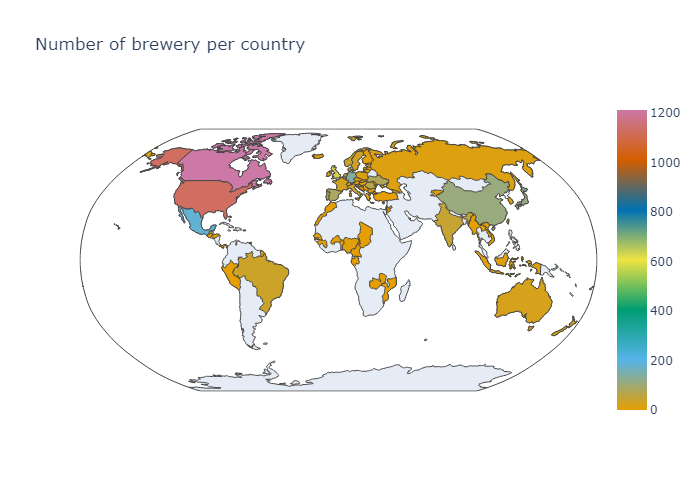

In [74]:
### Plot numbers of breweries on a world map

#Initialisation of country converter to iso-3
cc = coco.CountryConverter()

#Convert country name to ISO3
df_tmp = brewery_per_country.copy()
df_tmp = df_tmp.to_frame()
df_tmp.reset_index(inplace=True)
countries = pd.Series(df_tmp['brewery_location'])
iso3_codes = cc.pandas_convert(countries, to='ISO3') #convert the name of the country to ISO3  
df_tmp.insert(1,"code",iso3_codes) #add a code column corresponding to ISO3 abreviation of the country

#Plot 
data = dict(type='choropleth', colorscale = colorblindscale,
           locations = df_tmp['code'], 
           z = df_tmp['count'], 
           text = df_tmp['brewery_location'])

layout = dict(title = 'Number of brewery per country',
              geo = dict( projection = {'type':'robinson'},
                         showlakes = False, 
                         lakecolor = 'rgb(0,191,255)'))
fig = pg.Figure(data = [data], layout = layout)

plots(fig, "brewery_world_map")

# Number of reviews per country of origin

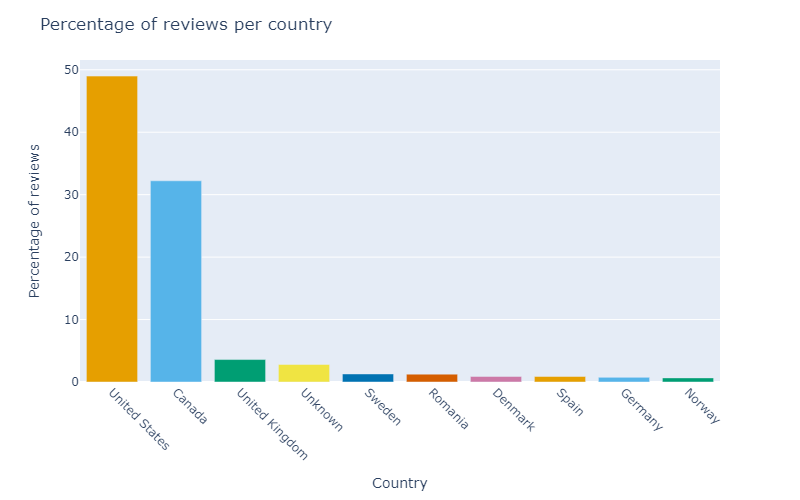

In [113]:
# Plot the percentage of reviews in histogram
percentage_review_top = percentage_review.head(10)
fig = px.bar(percentage_review_top, x=percentage_review_top.index, y=percentage_review_top, color=percentage_review_top.index, color_discrete_sequence=colorblindscale)
fig.update_layout(title_text='Percentage of reviews per country', xaxis_title="Country", yaxis_title="Percentage of reviews")
fig.update_xaxes(tickangle=45)
fig.update_layout(showlegend=False)
fig.update_layout(autosize=False, width=800, height=500)

plots(fig, "reviews_world_histogram")

In [ ]:
display(percentage_review.sort_values(ascending=False).head(10))

user_location
United States     48.985481
Canada            32.220369
United Kingdom     3.593651
Unknown            2.809842
Sweden             1.290318
Romania            1.261009
Denmark            0.892025
Spain              0.887516
Germany            0.740975
Norway             0.659062
Name: count, dtype: float64

Considering Canada, the US and the UK to be english speaking countries : over 82% of the reviews come from this countries. So one can assume that most of the reviews are in english

Number of different breweries in all websites : 4410


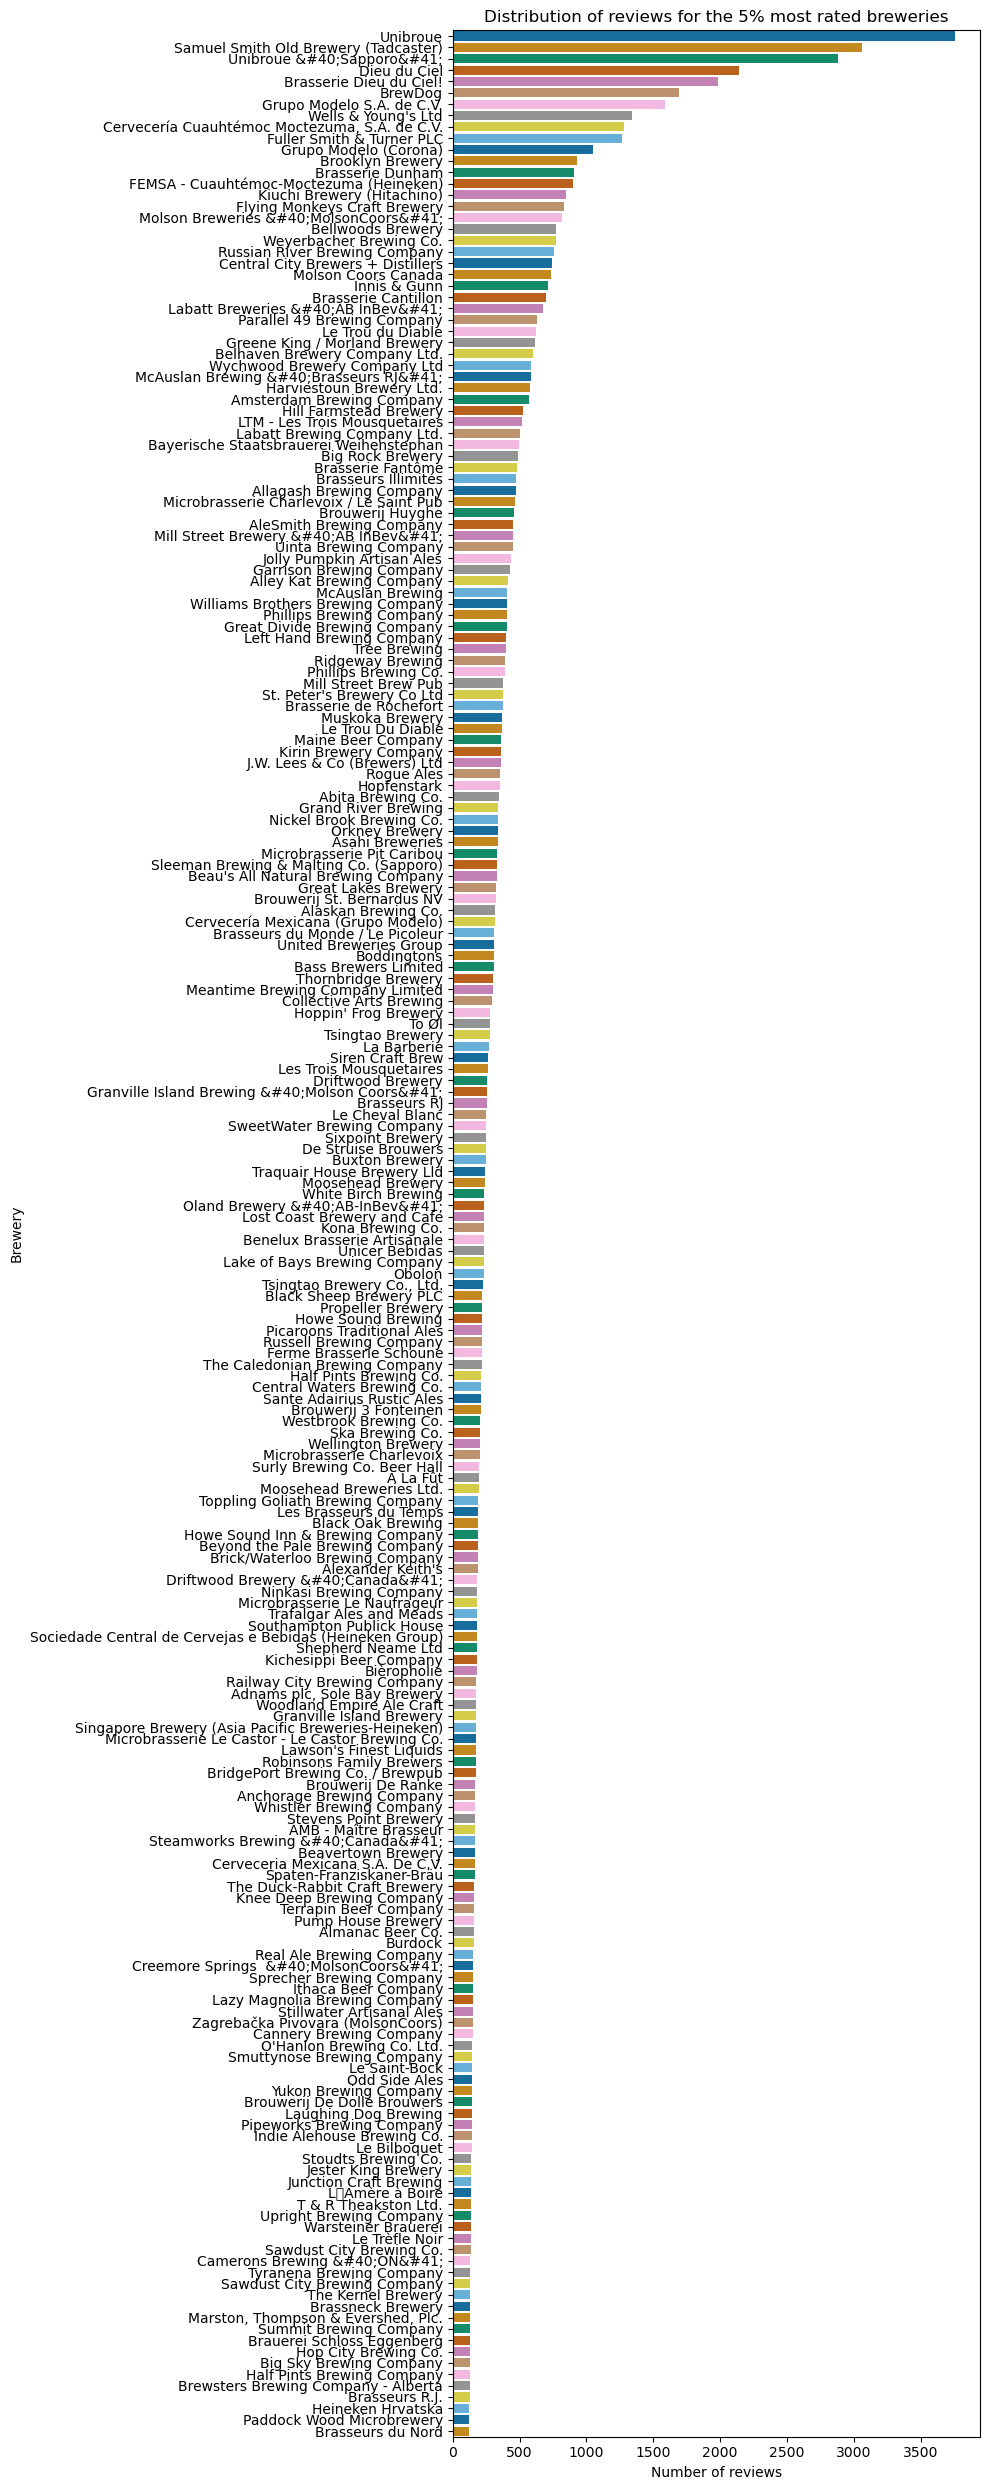

In [76]:
print(f"Number of different breweries in all websites : {len(all_data['brewery_id'].unique())}")

def filter_topk_breweries(df, k):
    # Find the top k% of breweries most rated
    brewery_count = pd.DataFrame({"count": df.groupby('brewery_name').apply(lambda x: len(x))})
    threshold = brewery_count['count'].quantile(k)
    top_breweries = brewery_count[brewery_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['brewery_name'].isin(top_breweries)]
    return df_filtered

ratings_all_top_breweries = filter_topk_breweries(all_data, 0.95)

# Plot the distribution of ratings for the top 5 breweries
fig = plt.figure(figsize=(10, 25))
sns.countplot(y='brewery_name', data = ratings_all_top_breweries, order = ratings_all_top_breweries['brewery_name'].value_counts().index, palette='colorblind')
plt.title('Distribution of reviews for the 5% most rated breweries')
plt.xlabel('Number of reviews')
plt.ylabel('Brewery')

plt.tight_layout()
plt.show()

**Style**

In [77]:
print(f"Number of different style of beers : {len(all_data['style'].unique())}")

def filter_topk_styles(df, k):
    # Find the top k% of breweries most rated
    style_count = pd.DataFrame({"count": df.groupby('style').apply(lambda x: len(x))})
    threshold = style_count['count'].quantile(k)
    top_styles = style_count[style_count['count'] > threshold].index

    # Filter DataFrame based on the selected brewery names
    df_filtered = df[df['style'].isin(top_styles)]
    return df_filtered

ratings_top_styles = filter_topk_styles(all_data, 0.95)

Number of different style of beers : 173


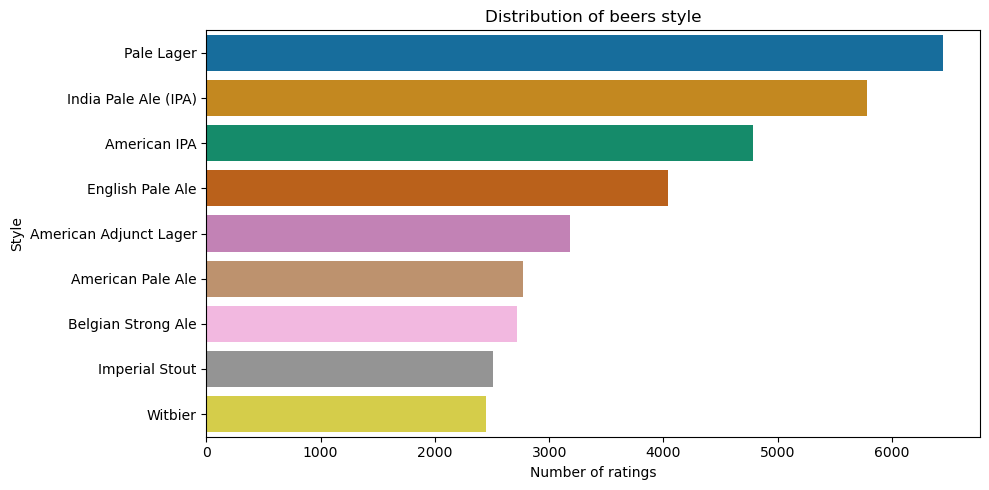

In [78]:
plt.figure(figsize=(10, 5))
sns.countplot(y='style', data=ratings_top_styles, order = ratings_top_styles['style'].value_counts().index, palette='colorblind')
plt.title('Distribution of beers style')
plt.xlabel("Number of ratings")
plt.ylabel("Style")

plt.tight_layout()
plt.show()

### 2. Numerical features

- abv
- appearance
- aroma
- palate
- taste
- overall
- rating

In [79]:
def plot_features(df, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating'] 
    fig, axes = plt.subplots(2, 4, figsize=(15,10))
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        data = df[~df[col].isna()]
        sns.histplot(data=data[col], bins=50, ax=ax) 
    fig.suptitle(title)
    fig.tight_layout()
    return fig

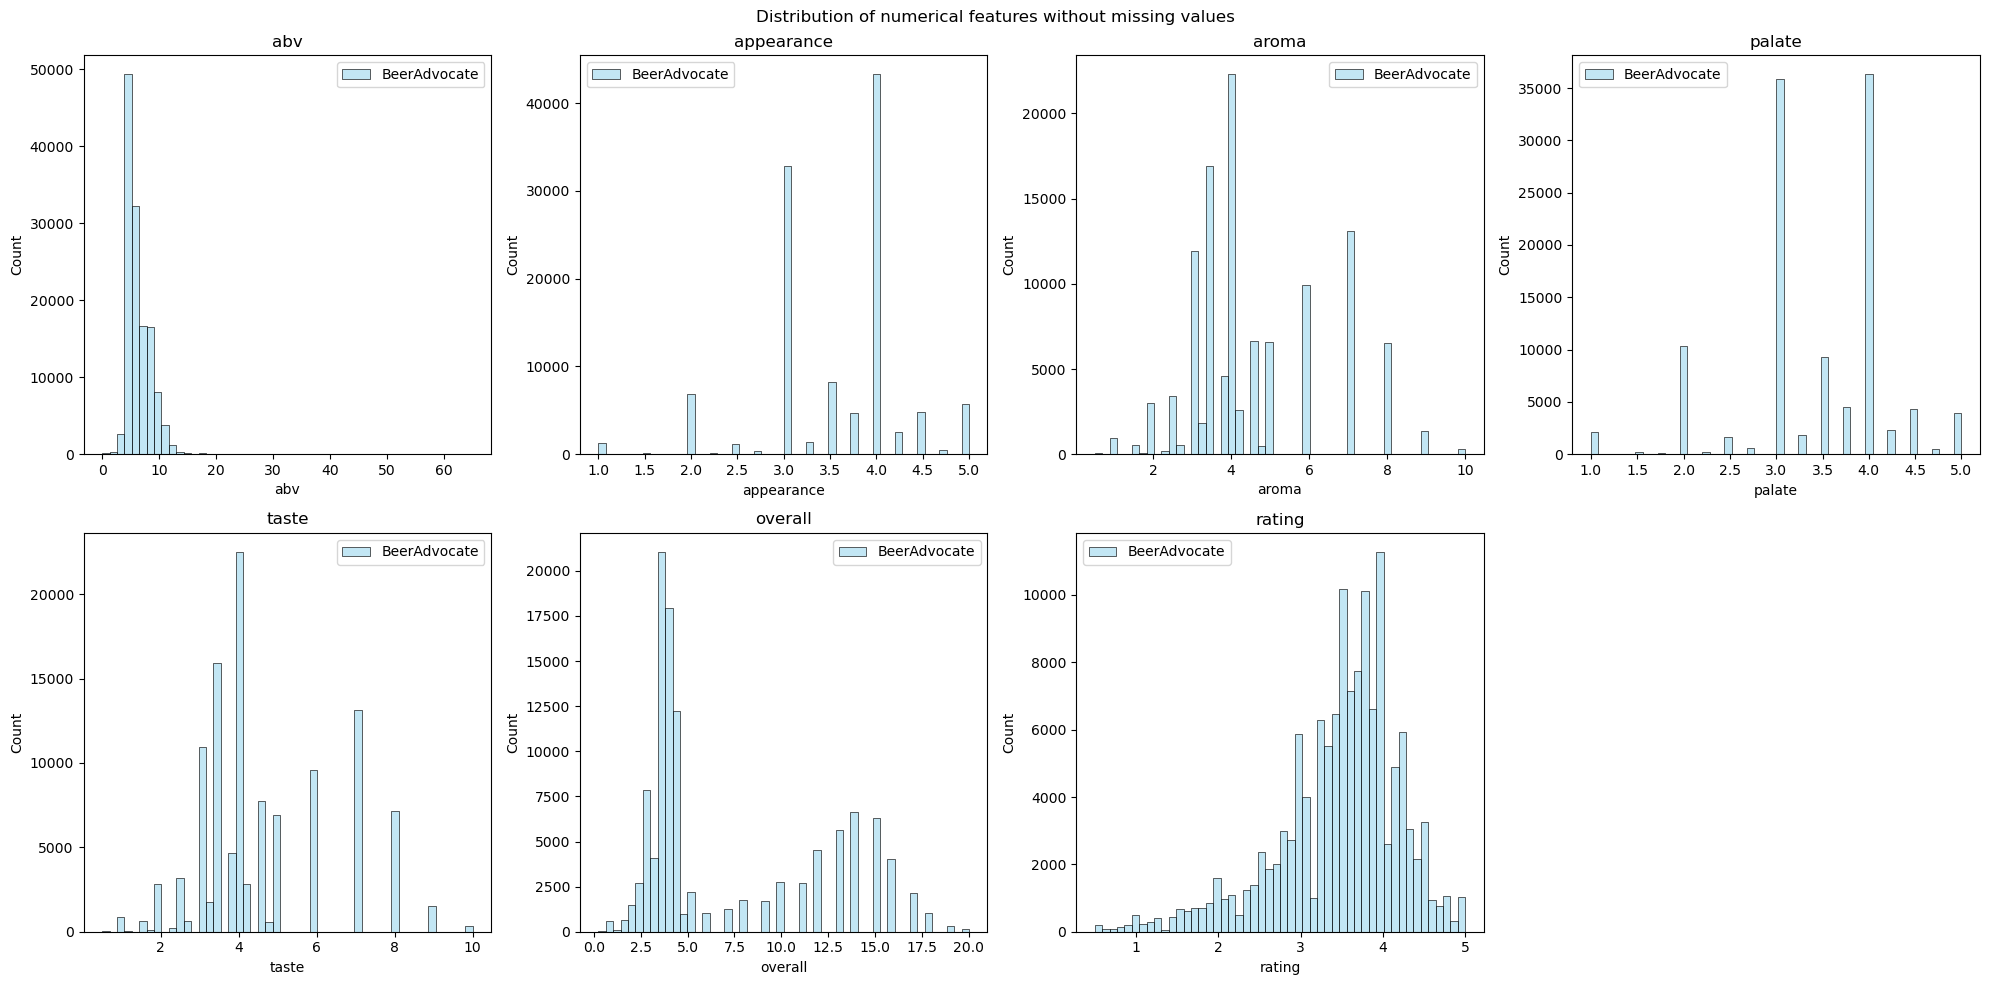

In [80]:
def plot_features(df1, title):
    continuous_cols = ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    fig, axes = plt.subplots(2, 4, figsize=(20,10))
    fig.delaxes(axes[1, 3])
    for i, col in enumerate(continuous_cols):
        ax = axes[i // 4, i % 4]
        sns.histplot(data=df1[~df1[col].isna()], x=col, bins=50, ax=ax, color='skyblue', alpha=0.5, label='BeerAdvocate')
        ax.set_title(col)
        ax.legend()
    fig.suptitle(title)
    fig.tight_layout()
    return fig

fig = plot_features(all_data, "Distribution of numerical features without missing values")
plt.show()

This mosaique plots highlights the differences in the notation between the two websites. Especially in teh appearance and palate categories: RateBeer users are not allowed to put non integer values. This is not the case for BeerAdvocate users. This is why the distribution of the RateBeer ratings is more discrete than the BeerAdvocate one.
One another side, the overall ratings in RateBeer and BeerAdvocate are not on the same scales: 5-scale for BeerAdvocate and 20-scale for RateBeer.

Later on in this notebooks, the values will be normalized for better comparison.

- Scores - styles

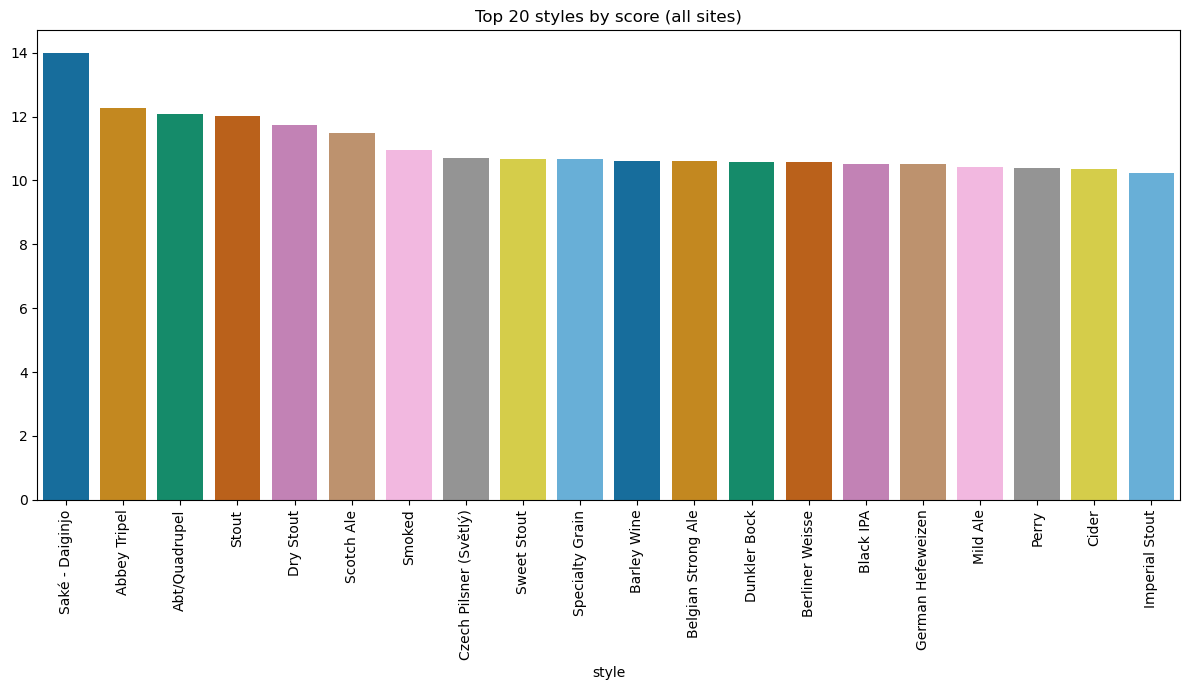

In [81]:
plt.figure(figsize=(12, 7))

# Best rated styles for both websites
sns.barplot(x=all_data.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).index,
            y=all_data.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).values, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Top 20 styles by score (all sites)')

plt.tight_layout()
plt.show()

Plotting the beer styles with the best average score gives a good idea of the top styles and will be useful for the final visualisation of the best breweries in the world with the best styles.

Text(0.5, 1.0, 'Distribution of score by style for top 20 styles')

<Figure size 1200x700 with 0 Axes>

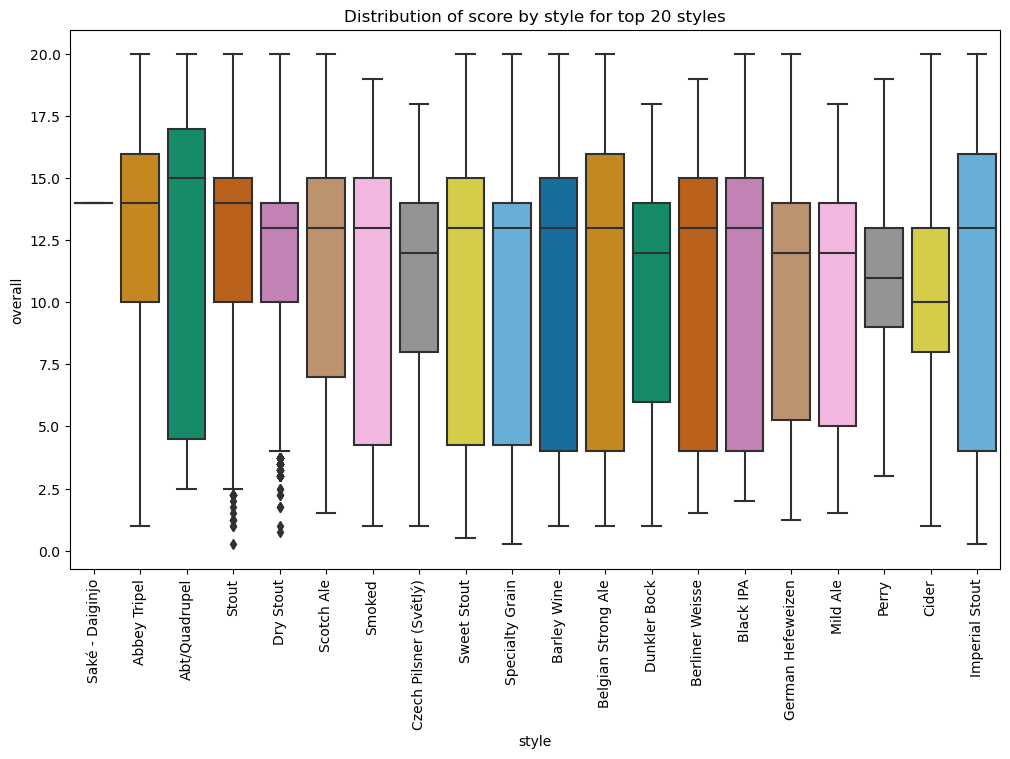

In [82]:
# Calculate the average score for each style and take the top 20 for RateBeer

def style_order_fcn(beers_df):
    style_order = beers_df.groupby('style')['overall'].mean().sort_values(ascending=False).head(20).index
    return style_order

style_order = style_order_fcn(all_data)

# Create the boxplots
plt.figure(figsize=(12, 7))

# Create the boxplot for BeerAdvocate
plt.figure(figsize=(12, 7))
sns.boxplot(x='style', y='overall', data=all_data[all_data['style'].isin(style_order)], order=style_order, palette=sns.color_palette("colorblind"))
plt.xticks(rotation=90)
plt.title('Distribution of score by style for top 20 styles')


To go deeper in the analysis of the top styles these boxplots show the repartition of the scores. These informations are useful to get a real idea of the overall score distribution.

- Correlations

In [83]:
def calculate_correlations(df1, df2):
        """
        Calculates the correlation between all numerical features.
        
        Parameters
        ----------
        df1 : DataFrame
                First dataframe containing all data
        df2 : DataFrame
                Second dataframe containing all data

        Returns
        -------
        None
        """
        # Extract numerical columns from the first dataframe and calculate correlation
        numerical_cols1 = df1.select_dtypes(include=['float64', 'int64']).columns
        corr1 = df1[numerical_cols1].corr()

        # Extract numerical columns from the second dataframe and calculate correlation
        numerical_cols2 = df2.select_dtypes(include=['float64', 'int64']).columns
        corr2 = df2[numerical_cols2].corr()

        # Create subplots for heatmaps of correlations between numerical features in both dataframes
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        sns.heatmap(corr1, annot=True, ax=axes[0])
        sns.heatmap(corr2, annot=True, ax=axes[1])
        
        # Set titles for the subplots
        axes[0].set_title('Correlation between numerical features in BeerAdvocate')
        axes[1].set_title('Correlation between numerical features in RateBeer')
        plt.show()

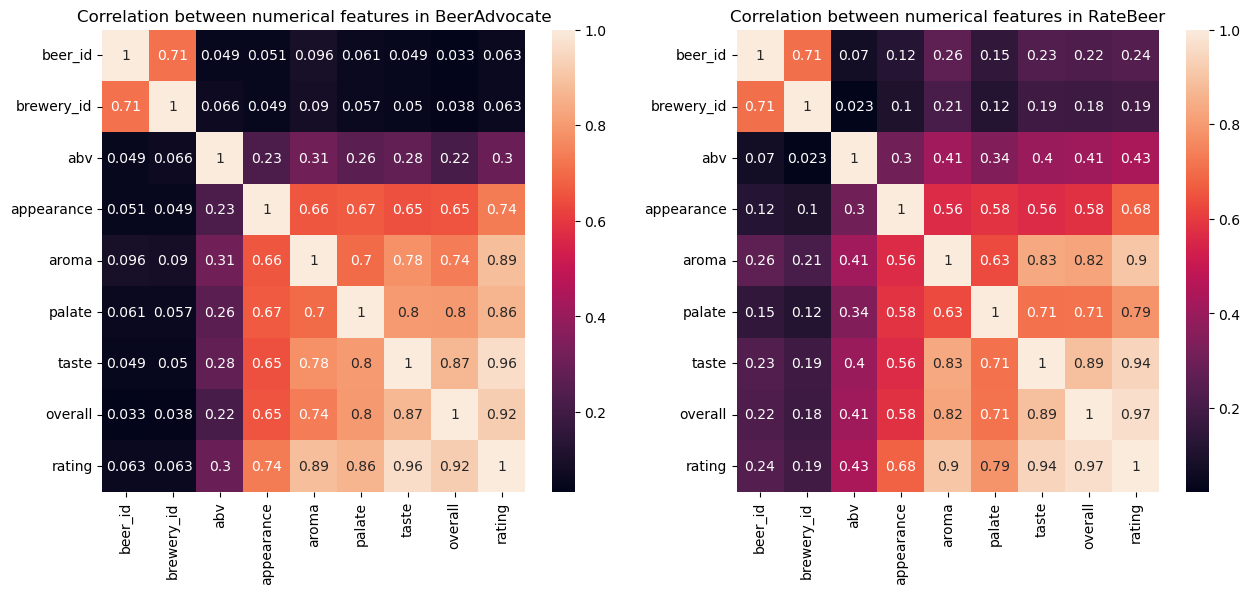

In [84]:
calculate_correlations(ratings_BA, ratings_RB)

Performing correlation help having a better understanding of the beer rating. One can note that the most relevant part is the lower right corner of the correlation matrix, as the correlation between beer_id and brewery_id might not tell us much. The lower right areas of the matrices look warmer, translating a high correlation between features. Looking at the rating, from the matrices one can see that a beer rater tends to put high rate scores to tastier, and more complex beers.

One difference between the 2 websites is that the correlations are different especially in the appearance where BeerAdvocate's users look like they are more focused towards it when rating the beverage.

### 3. Textual reviews

**Number of words in textual reviews**

In [85]:
mean_words_all = np.mean(all_data["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of both websites : {mean_words_all}")

Average number of words in textual reviews of both websites : 354.71857997414855


**N most common words in textual reviews**

In [86]:
def get_top_n_i_gram(corpus, i, n=None):
    """
    Extracts the top 'n' n-grams from a corpus.
    
    Parameters
    ----------
    corpus : Series or list
        Contains text data.
    i : int
        Specifies the 'i' in n-grams.
    n : int, optional
        Specifies the number of top n-grams to return. Default is None.

    Returns
    -------
    words_freq : list
        Contains tuples of n-grams and their frequencies.
    """
    # Drop rows with NaN values in the 'text' column
    corpus = corpus.dropna()
    # Fit CountVectorizer with specified n-gram range
    vec = CountVectorizer(ngram_range=(i,i)).fit(corpus)
    # Transform the corpus into a bag of words
    bag_of_words = vec.transform(corpus)
    # Sum the occurrences of each word across the corpus
    sum_words = bag_of_words.sum(axis=0) 
    # Create a list of tuples containing words and their frequencies
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # Sort the list by frequency in descending order
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [87]:
# can take 5-7 min to run
N = 20

common_unigrams_all = get_top_n_i_gram(all_data['text'], 1, N)
common_bigrams_all = get_top_n_i_gram(all_data['text'], 2, N)
common_trigrams_all = get_top_n_i_gram(all_data['text'], 3, N)

In [88]:
def plot_ngrams(common_unigrams, common_bigrams, common_trigrams):
    # Creating subplots
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    # Subplot 1: Common Unigrams
    df1 = pd.DataFrame(common_unigrams, columns=['Review Text', 'count'])
    df1.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[0])
    axes[0].set_title(f'Top {N} words in reviews')

    # Subplot 2: Common Bigrams
    df2 = pd.DataFrame(common_bigrams, columns=['Review Text', 'count'])
    df2.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[1])
    axes[1].set_title(f'Top {N} bigrams in reviews')

    # Subplot 3: Common Trigrams
    df3 = pd.DataFrame(common_trigrams, columns=['Review Text', 'count'])
    df3.groupby('Review Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', y='Count', ax=axes[2])
    axes[2].set_title(f'Top {N} trigrams in reviews')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

##### All websites

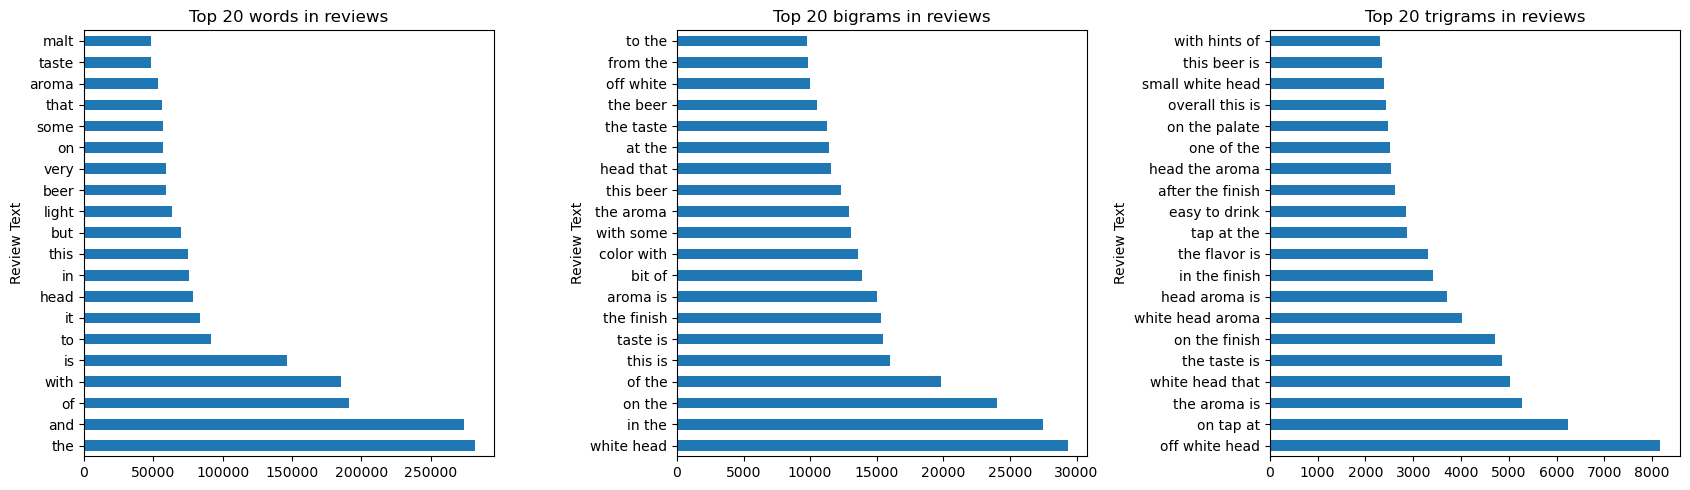

In [89]:
display(Markdown("##### All websites"))
plot_ngrams(common_unigrams_all, common_bigrams_all, common_trigrams_all)

With these plots, we observe that there are a lot of words not interesting to describe a beer but just useful to write a sentence (eg: and, with,the...). This is what we call stopwords. To have a relevant analysis in the next part we will process the sentences.  

---

## Data preprocessing

### Transformation

- Standardization of numerical features

In [90]:
def normalize_numerical_data(df):
    """
    Normalizes the numerical features of the DataFrame.
    
    Parameters
    ----------
    df : DataFrame
        Containing all data

    Returns
    -------
    df : DataFrame
        Containing all data with normalized numerical features.
                
    """
    df2 = df.copy()
    numerical = df2._get_numeric_data().columns
    for col in numerical:
        df2[col] = (df2[col] - df2[col].mean()) / df2[col].std()
    return df2

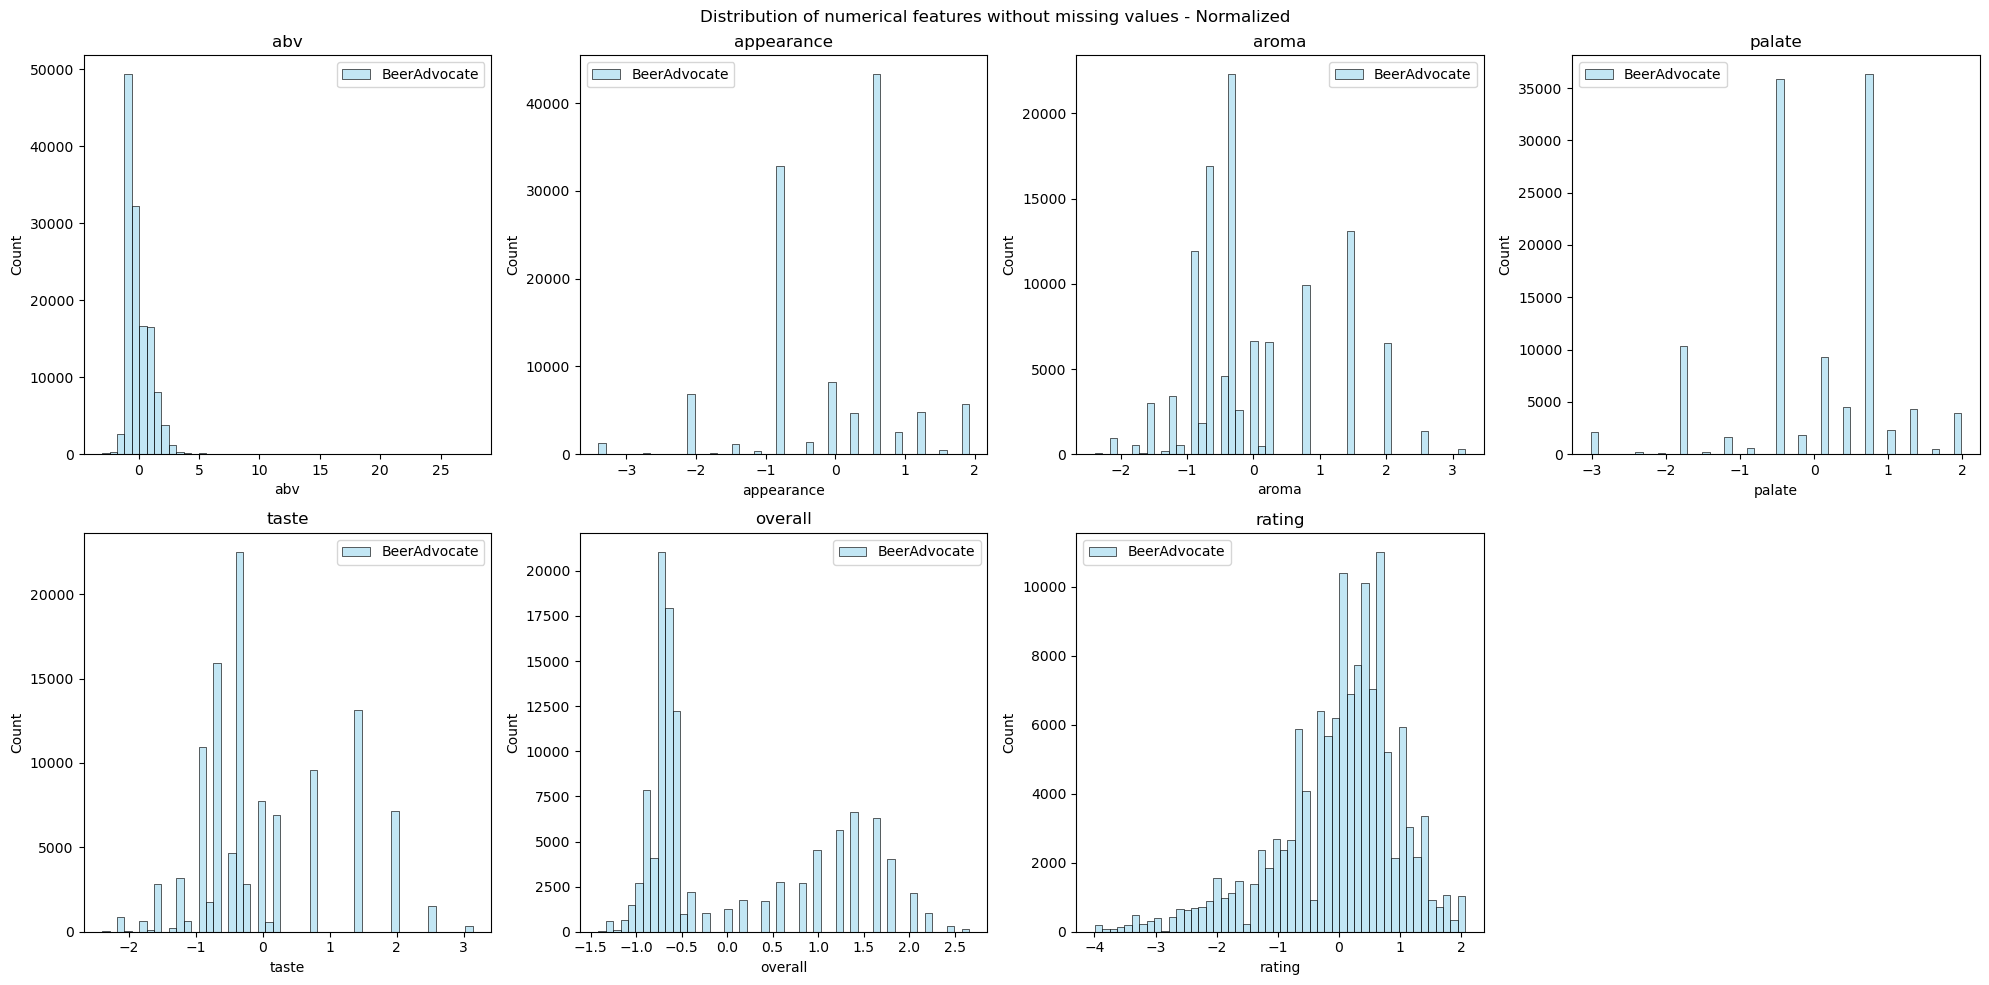

In [91]:
fig = plot_features(normalize_numerical_data(all_data), "Distribution of numerical features without missing values - Normalized")

After standardization, the distributions of the different features are made comparable across the 2 websites.

The overall scores from the 2 websites follow a very similar distribution although in the beginning they were not on the same scale. This shows that we have enough colledted data.

- **date** feature

The date feature is hereafter reformated to be processed more easily.

In [92]:
def add_rating_month_feature(df):
    """
    Adds a 'month' feature to the DataFrame based on the 'date' column.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including a 'date' column.

    Returns
    -------
    df_m : DataFrame
        Contains the original data with an additional 'month' feature.
    """
    # Create a copy of the DataFrame
    df_m = df.copy()
    # Conversion of date feature from timestamp to text date
    pd.to_numeric(df_m['date'], errors='coerce', downcast='integer')
    # Convert 'date' to datetime and extract the date
    df_m.date = all_data.date.apply(lambda d: pd.to_datetime(d, unit='s'))
    df_m['date'] = df_m['date'].dt.date
    df_m.head(2)

    # Extract the month from the 'date' column and add it as a new feature 'month'
    df_m['month'] = pd.to_datetime(df_m['date']).dt.month

    return df_m

In [93]:
all_data_monthly = add_rating_month_feature(all_data)

- **text** feature

In [94]:
nltk.download('words')
nltk.download('stopwords') # Download NLTK stopwords
nltk.download('wordnet')   # Lemmatization
nltk.download('words')
english_words=set(words.words())
# Get the set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Charles\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


As mentioned previously to have a relevant analysis, we need to transform review texts. To facilitate the comparison we have first remove punctuation, capital letters and remove the stopwords we have talked about. Another function lemmatize the senctences that means "grouping together the inflected forms of a word so they can be analysed as a single item" (Wikipedia definition). For example drinking will be rewrite drink.
We have also removed not english-words to facilitate the analysis and the polarity sentiment. Indeed, in the EDA part we could see that there are different languages in the reviews.

In [95]:
def preprocess_sentences(df):    
    # Remove rows with no sentences (NaN values)
    df = df[~df['text'].isnull()]

    # Remove punctuation and convert to lowercase
    def clean_text(sentence):
        translator = str.maketrans('', '', string.punctuation)
        cleaned = sentence.translate(translator).lower()
        return cleaned

    # Function to lemmatize 
    def lemmatize_text(sentence):
        tokens = word_tokenize(sentence)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)

    # Function to remove stop words
    def remove_stopwords(sentence):
        tokens = word_tokenize(sentence)
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)

    # Function to remove non-english words
    def keep_only_english(sentence):
        return " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in english_words or not w.isalpha())
    
    df['cleaned_text'] = df['text'].apply(clean_text)
    df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
    df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
    df['cleaned_text'] = df['cleaned_text'].apply(keep_only_english)
    
    return df

def compute_top_words(df):
    # Split the sentences into individual words
    all_words = ' '.join(df['cleaned_text']).split()

    # Count word occurrences
    word_counts = Counter(all_words)

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Convert to DataFrame for easy plotting
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

In [96]:
# can take 6-8 min to run on all the sentences
all_data_cleaned = preprocess_sentences(all_data)

# correction to remove missing sentences
all_data_cleaned = all_data_cleaned[all_data_cleaned['cleaned_text'] != 'nan']

In [97]:
# Before preprocessing of the sentences
print("Before cleaning")
mean_words_all = np.mean(all_data["text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_all}")

# After preprocessing of the sentences
print("\nAfter cleaning")
mean_words_all = np.mean(all_data_cleaned["cleaned_text"].apply(lambda row : len(str(row))))
print(f"Average number of words in textual reviews of BA : {mean_words_all}")

Before cleaning
Average number of words in textual reviews of BA : 354.71857997414855

After cleaning
Average number of words in textual reviews of BA : 264.49247073014294


Top N most common words after preprocessing

We see that some words are very recurring like aroma, taste, sweet both in words and expressions. This analysis can be linked to the correlation matrix where we can see that the rating is correlated to these aspects in the numerical ratings. So these are clearly most important aspects in the way to rate beers.

---

## Feasibility check of project's methods

This part aims at verifying if our project plans are reasonable and sound. We will thus check that the ratings and the sentiment analysis (such as polarity and subjectivity) are not homogeneous across breweries, styles and by extension to users. It will thus support our idea to correct the ratings based on the reviews.

### 1. Ratings distribution

**Ratings intervals**

In [98]:
all_data['overall'].dtypes

dtype('float64')

This stacked barplot represents the number of beers per brewery that has the biggest number of 5 rated beers, the stacked plot is used to show the proportion of beers rated in the different intervals of score. This representation gives a more detailed representation of the distribution of scores per beers for each brewery.

One can see that the ratings are not equally distributed for the same brewery, especially for the breweries from BeerAdvocate. One user very unhappy with a beer from a brewery in BeerAdvocate could thus have a big influence on the average grade of the brewery and its rating could thus be ponderated in the new ranking system we want to implement as part of our research question.

**Ratings in function of the time**

To asses whether the yearly evolution of the tastes changes, the following plot shows the evolution of the average rating per month along the years

We would like to determine the evolution in time of the prefered beer style in RateBeer and the prefered beer style in function of months. This will be interesting to determine the best beer in function of the season for example.

### 2. Sentiment analysis

In [99]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

**Polarity - subjectivity per website**
All sites

In [100]:
# can take 6-8 min to run on all the sentences

# with original text
all_data_cleaned['polarity_text'] = all_data_cleaned['text'].apply(lambda x: getPolarity(x))
all_data_cleaned['subjectivity_text'] = all_data_cleaned['text'].apply(lambda x: getSubjectivity(x))
all_data_cleaned['polarity_Analysis'] = all_data_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))
# with cleaned text
all_data_cleaned['polarity_cleaned_text'] = all_data_cleaned['cleaned_text'].apply(lambda x: getPolarity(x))
all_data_cleaned['subjectivity_cleaned_text'] = all_data_cleaned['cleaned_text'].apply(lambda x: getSubjectivity(x))
all_data_cleaned['cleaned_polarity_Analysis'] = all_data_cleaned['polarity_text'].apply(lambda x: getAnalysis(x))

In [101]:
display(all_data_cleaned.head(2))

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_location,brewery_name,date,overall,...,user_location,user_name,review,cleaned_text,polarity_text,subjectivity_text,polarity_Analysis,polarity_cleaned_text,subjectivity_cleaned_text,cleaned_polarity_Analysis
9162,6.0,5.0,4.0,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1049882400,3.75,...,United States,Gusler,NaN,magnificent site tired old eye see beautiful i...,0.23750,0.582407,Positive,0.237500,0.582407,Positive
1192,6.0,5.0,3.5,12.0,Bert Grant's Imperial Stout,5.0,United States,Yakima Brewing Co. / Bert Grant's Ales,1053338400,4.25,...,United States,Dogbrick,NaN,thanks trade considering favorite style beer m...,0.18114,0.517105,Positive,0.179167,0.528125,Positive


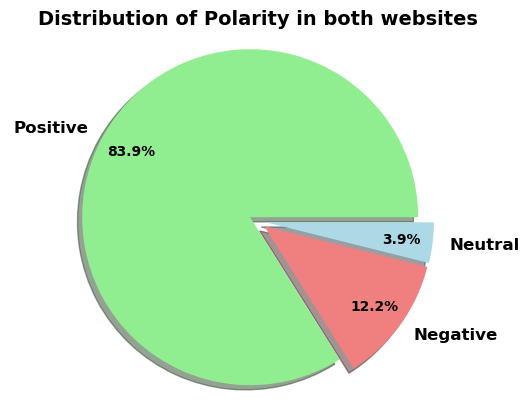

In [102]:
def plot_pie_chart(df, title):
    polarity_counts = df['polarity_Analysis'].value_counts()

    labels = polarity_counts.index
    sizes = polarity_counts.values
    myexplode=[0.05, 0.05, 0.05]
    category_color = {'Positive': 'lightgreen', 'Neutral': 'lightblue', 'Negative': 'lightcoral'}
    
    colors = [category_color[label] for label in labels]
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, explode=myexplode, colors= colors, autopct='%1.1f%%', startangle=0, pctdistance=0.81, shadow=True)

    fig.patch.set_facecolor('none')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Customize the appearance of labels and autopct values
    plt.setp(texts, fontsize=12, fontweight='bold', color= 'black')
    plt.setp(autotexts, fontsize=10, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', color='black')
    plt.show()

plot_pie_chart(all_data_cleaned, 'Distribution of Polarity in both websites')

We can see with these plots that the distribution of opinions is unbalanced, for both websites peoples seem to mostly appreciate beers. However, it can be interested to check the distribution more precisely to verify if some people have extreme opinions. 

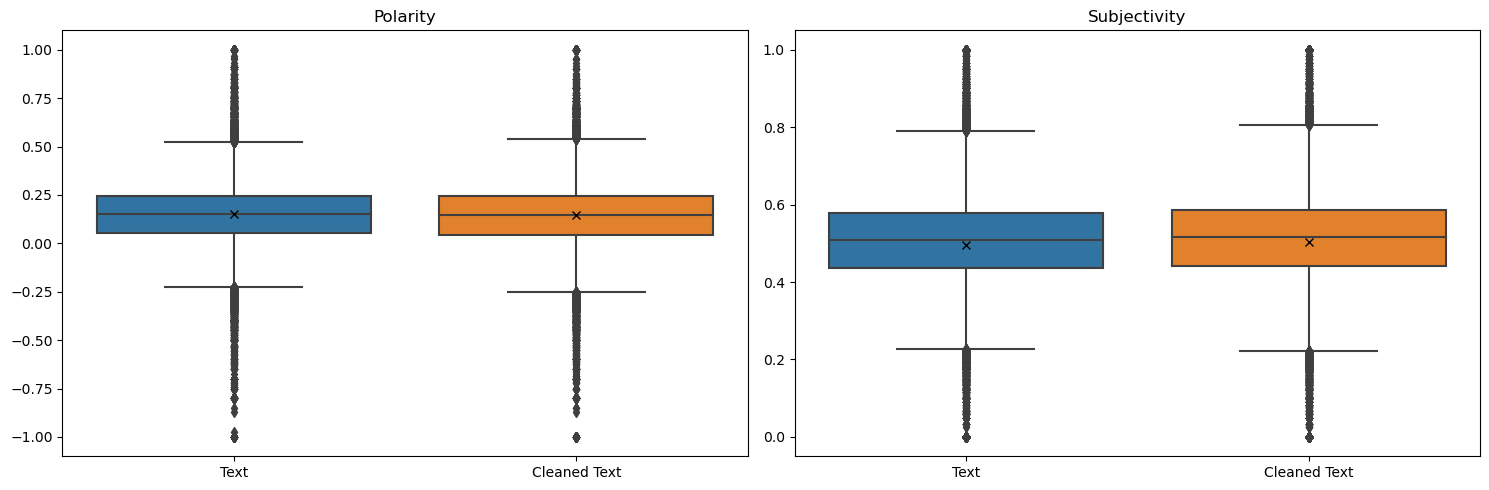

In [103]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data = all_data_cleaned[['polarity_text', 'polarity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])

sns.boxplot(data = all_data_cleaned[['subjectivity_text', 'subjectivity_cleaned_text']], showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])
for i in range(2):
    axs[i].set_xticklabels(['Text', 'Cleaned Text'])

axs[0].set_title(f"Polarity")
axs[1].set_title(f"Subjectivity")
plt.tight_layout()
plt.show()

These polarity’s boxplots and subjectivity’s boxplots help us to valide our idea. Indeed, we observe that our idea to create a new ranking’s system with less subjectivity, and with less weight for extreme user’s opinion which can be ponderated to limit their influence on the beer’s ranking seems to be feasible and relevant. Then, the average which is not a robust parameter would be fairer. We also see that there is not much difference between the text and cleaned text, so that we will later only use the cleaned text to perform sentiment analysis.

**Polarity - subjectivity per brewery**

One can note that the polarity and subjectivity of textual reviews depends on the brewery we look at. Some have more extreme outliers than others and typically for BeerAdvocate, one can note that even the mean of the polarity is different.

**Polarity - subjectivity per style**

In [104]:
def plot_polarity_subjectivity_per_topk_style(df):
    k_styles = 0.9
    ratings_topk_styles = filter_topk_styles(df, k_styles)

    fig, axs = plt.subplots(1,2, figsize=(15, 4), sharey = True)
    sns.boxplot(data = ratings_topk_styles, x = 'polarity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[0])
    sns.boxplot(data = ratings_topk_styles, x = 'subjectivity_text', y = 'style', showmeans=True, meanprops={"marker":"x", "markerfacecolor":"black", "markeredgecolor":"black"}, ax = axs[1])

    axs[0].set_title(f"Polarity top {np.round(100*(1-k_styles),0)} % styles")
    axs[1].set_title(f"Subjectivity top {np.round(100*(1-k_styles),0)} % styles")

    plt.tight_layout()
    plt.show()

##### all websites

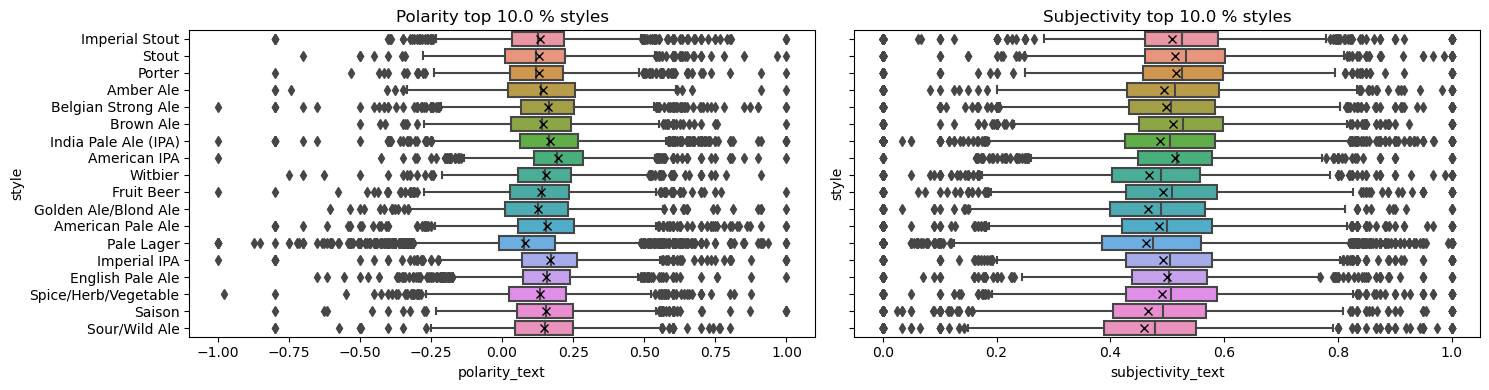

In [105]:
display(Markdown("##### all websites"))
plot_polarity_subjectivity_per_topk_style(all_data_cleaned)

One can note that the polarity and subjectivity of textual reviews depends also on the style of the beer we look at. Some have more extreme outliers than others eventhough one can note that the differences of polarity and subjectivity of the textual reviews across styles are less important than for breweries.

It thus support the feasibility of our research project to create a weighted ranking system taking into account the discrepancies of polarity and subjectivity of the textual reviews across breweries, styles and ultimately users to have an enhanced ranking system that leverage numerical ratings and textual reviews.

## P3 Best breweries

## Figures in HTML format

In [106]:
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import ttest_rel
from scipy.stats import gaussian_kde

# A METTRE DANS LE NOTEBOOK 3.2.3

In [107]:
from scipy.stats import mannwhitneyu

In [108]:
def link_extreme_plotly(df, polarity_or_rating):
    """
    Compute the max and the min for the polarity and plot the subjectivity vs polarity for the extreme reviews.
    
    Parameters
    ----------
    df : DataFrame
        Contains data including 'polarity_text' and 'subjectivity_text' columns.
    polarity_or_rating : str
        If polarity_or_rating = 'polarity_text', use the polarity. If polarity_or_rating = 'rating', use the rating.

    Returns
    -------
    fig : Figure
        Showing the link between subjectivity and polarity for the extreme reviews.
    p_value_pos : float
        p-value of the t-test for positive reviews.
    t_stat_pos : float
        t-statistic of the t-test for positive reviews.
    p_value_neg : float
        p-value of the t-test for negative reviews.
    t_stat_neg : float
        t-statistic of the t-test for negative reviews.
    """
    # Define max and min of the polarity
    q1 = df[polarity_or_rating].quantile(0.25)
    q3 = df[polarity_or_rating].quantile(0.75)
    iqr = q3 - q1

    max_value = q3 + 1.5 * iqr
    min_value = q1 - 1.5 * iqr

    # Filter the dataset to get only the max extreme values
    df_positive = df[df[polarity_or_rating] > max_value]
    df_negative = df[df[polarity_or_rating] < min_value]

    # Box plot for the subjectivity for positive reviews
    trace_positive = go.Box(x=df_positive['subjectivity_text'], name='Positive Reviews', line=dict(color='green'))

    # Box plot for all reviews
    trace_all = go.Box(x=df['subjectivity_text'], name='All Reviews', line=dict(color='blue'))

    # Box plot for the subjectivity for negative reviews
    trace_negative = go.Box(x=df_negative['subjectivity_text'], name='Negative Reviews', line=dict(color='red'))

    # Create a figure and add the traces
    fig = go.Figure(data=[trace_positive, trace_all, trace_negative])

    # Update layout and show figure
    fig.update_layout(title=('Subjectivity for extreme reviews based on' + ' ' + polarity_or_rating), xaxis_title='Subjectivity', width=800, height=400, legend=dict(yanchor="bottom", y=0.01, xanchor="left", x=0.01))

    # Adapt the dataset to perform Mann-Whitney U test (appropriate when the data may be skewed or not normally distributed.)
    # Positive reviews

    #The function mannwhitneyu does not accept empty distributions, this is why we need to check if the dataframe is empty or not
    if len(df_positive) == 0:
        p_pos = "NaN"
        stat_pos = "NaN"
    else:
        len_pos_df = len(df_positive)
        df_pos_bootstrap_sample = df.sample(n=len_pos_df, replace=True)

        # Perfoming Mann-Whitney U test
        stat_pos, p_pos = mannwhitneyu(df_positive['subjectivity_text'], df_pos_bootstrap_sample['subjectivity_text'])

    # Negative reviews
    if len(df_negative) == 0:
        p_neg = "NaN"
        stat_neg = "NaN"
    else:
        len_neg_df = len(df_negative)
        df_neg_bootstrap_sample = df.sample(n=len_neg_df, replace=True)

        # Perfoming Mann-Whitney U test
        stat_neg, p_neg = mannwhitneyu(df_negative['subjectivity_text'], df_neg_bootstrap_sample['subjectivity_text'])

    return fig, stat_pos, p_pos, stat_neg, p_neg

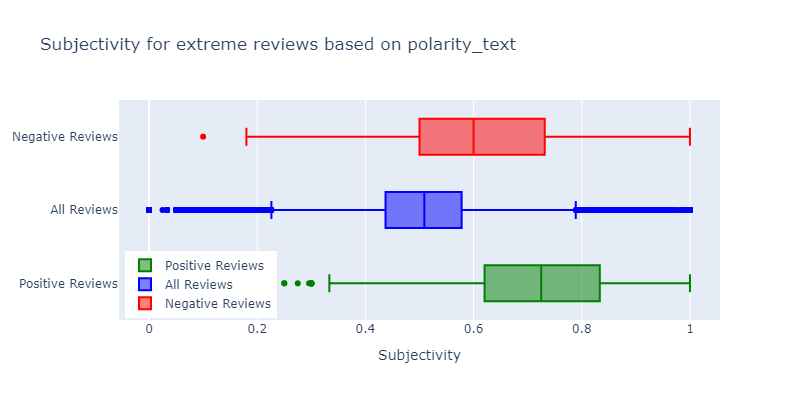

p_value for positive reviews: 2.4553812838814618e-248
p_value for negative reviews: 4.21534376551749e-66


In [109]:
## Subjectivity for extreme polarites
# For positive reviews
fig, stat_pos_pol, p_pos_pol, stat_neg_pol, p_neg_pol = link_extreme_plotly(all_data_cleaned, 'polarity_text')

display(plot_format(fig, "Subjectivity_for_extreme_polarities"))

# Convert the figure to a static image file

# T-test for positivereviews
print(f'p_value for positive reviews: {p_pos_pol}')

# T-test for negative reviews
print(f'p_value for negative reviews: {p_neg_pol}')

The above plot shows the box plots for the subjectivity of all the reviews (in blue), against the distribution of subjectivity for reviews with extreme polarities (for positive reviews (in green) the distribution of subjectivity for reviews with a polarity above the computed maximum and for negative reviews (in red) below the computed min). 

#### Positive reviews
The above plot shows that the boxplots for positive and all reviews do not overlap, it suggests that there is a substantial difference between the central tendencies of the two groups. So it seems that extremly positive reviews have a significantly higher subjectivity, this reviews need to be corrected to obtain a more ranking that is more fair.

#### Negative reviews
On the other hand the box plots for negative and all reviews partially overlap, it suggests that there are some similarities in the central 50% of the data. To conclude on the difference between the two distribution, the p-value needs to be looked at. In fact, the null hypothesis : " The two distribution have the same mean" is rejected since the p-value for negative reviews << 0.05. So on might say that the difference is significant and extremely negative reviews need to be corrected to get a more fair ranking.

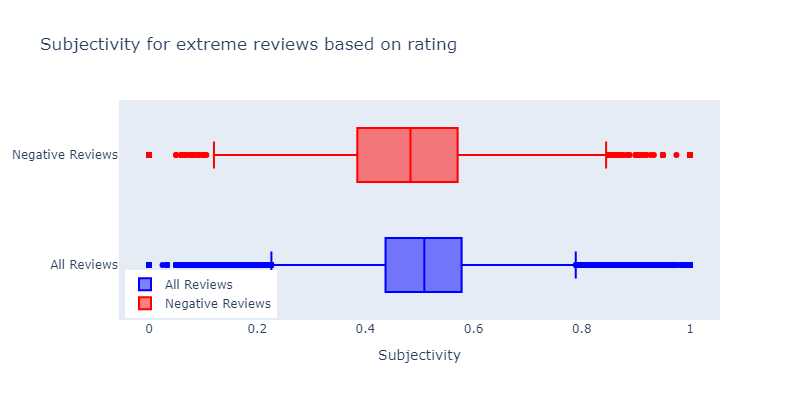

p_value for positive reviews: NaN
p_value for negative reviews: 6.079131155405446e-29


In [110]:
## Subjectivity for extreme ratings
# For positive reviews
fig, stat_pos_rat, p_pos_rat, stat_neg_rat, p_neg_rat = link_extreme_plotly(all_data_cleaned, 'rating')

display(plot_format(fig, "Subjectivity_for_extreme_ratings"))

# T-test for positivereviews
print(f'p_value for positive reviews: {p_pos_rat}')

# T-test for negative reviews
print(f'p_value for negative reviews: {p_neg_rat}')